# Run if on Google Colab

In [1]:
%pip install git+https://github.com/deepmind/dm-haiku
%pip install jaxopt
%pip install optax

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-wf1pxzy5
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-wf1pxzy5
  Resolved https://github.com/deepmind/dm-haiku to commit 77e73d6bdd0a0a04dacd2e58ee23f41a0f8a260d
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.14.dev0-py3-none-any.whl size=373703 sha256=f0f23bc26a2bb89336801b3e6624a931669d88eb2b1c3c244b66dbad66770bae
  Stored in directory: /tmp/pip-ephem-wheel-cache-ge7zi3yo/wheels/86/29/0a/454c478e7217c383ee3d05aa43cbeff48284c23430f59d0c4f
Successfully built dm-haiku
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 4.6 MB/s eta 0:00:00


In [2]:
# Set-up google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/My Research/Markov Exchange Economy

/content/drive/MyDrive/My Research/Markov Exchange Economy


# Set up Environment

In [4]:
# Import packages
from typing import NamedTuple, Callable, Dict, List, Tuple
import functools
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import haiku as hk
import numpy as np
import optax
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from itertools import product
import pickle
from flax import struct
from mynetworks import *
from myjaxutil import *
import os


#Set seed
SEED = 42
ZERO_CLIP_MIN = 1e-4

# myjaxutils

In [5]:
class TrainState(NamedTuple):
    """
    A class that stores the state of the training.

    Attributes:
    -----------
    optimizer: optax.TransformUpdateFn
        The optimizer function used for updating the parameters.
    state: optax.OptState
        The optimizer state.
    """

    update: optax.TransformUpdateFn
    state: optax.OptState


def init_optimiser(lr, params, name="adam", **kwargs):
    """
    Initializes an optimizer.

    Parameters:
    -----------
    lr: float
        The learning rate.
    params: Any
        The parameters to be optimized.
    name: str
        The name of the optimizer. Default is "adam".

    Returns:
    --------
    TrainState
        The state of the training.
    """
    if name == "sgd":
        optimizer = optax.sgd(lr, **kwargs)
    elif name == "adam":
        optimizer = optax.adam(lr, **kwargs)
    elif name == "rmsprop":
        optimizer = optax.rmsprop(lr, **kwargs)
    elif name == "optimistic_gradient_descent":
        optimizer = optax.optimistic_gradient_descent(lr, **kwargs)
    else:
        raise ValueError(f"Invalid optimizer name: {name}")

    opt_init, opt_update = optimizer
    opt_state = opt_init(params)
    return TrainState(opt_update, opt_state)


def minimize(
    f, x0, proj=lambda x: x, num_iters=1000, lr=1e-2, name="adam", verbose=True
):
    """
    Minimizes a function using an optimizer.

    Parameters:
    -----------
    f: Callable
        The function to be minimized.
    x0: Any
        The initial value of the parameters.
    proj: Callable
        The projection function. Default is the identity function.
    num_iters: int
        The number of iterations. Default is 1000.
    lr: float
        The learning rate. Default is 1e-2.
    name: str
        The name of the optimizer. Default is "adam".
    verbose: bool
        Whether to print the loss at each iteration. Default is True.

    Returns:
    --------
    Any
        The optimized parameters.
    """
    # Define the gradient function
    val_grad_f = jax.value_and_grad(f)

    # Define the optimizer
    opt_update, opt_state = init_optimiser(lr, x0, name)

    # Define the update function
    @jax.jit
    def update(x, opt_state):
        loss, grads = val_grad_f(x)
        updates, new_state = opt_update(grads, opt_state, x)
        new_x = optax.apply_updates(x, updates)
        new_x = proj(new_x)
        return new_x, new_state

    # Minimize the function
    x = x0
    for i in range(num_iters):
        if verbose:
            if i % 100 == 0:
                print(f"Iteration {i}, loss {f(x)}")
        (loss, x), opt_state = update(x, opt_state)

    return (loss, x)


def maximize(
    f, x0, proj=lambda x: x, num_iters=1000, lr=1e-2, name="adam", verbose=True
):
    """
    Maximizes a function using an optimizer.

    Parameters:
    -----------
    f: Callable
        The function to be maximized.
    x0: Any
        The initial value of the parameters.
    proj: Callable
        The projection function. Default is the identity function.
    num_iters: int
        The number of iterations. Default is 1000.
    lr: float
        The learning rate. Default is 1e-2.
    name: str
        The name of the optimizer. Default is "adam".
    verbose: bool
        Whether to print the loss at each iteration. Default is True.

    Returns:
    --------
    Any
        The optimized parameters.
    """
    return minimize(
        lambda x: -f(x),
        x0,
        proj=lambda x: x,
        num_iters=1000,
        lr=1e-2,
        name="adam",
        verbose=verbose,
    )


# Markov Exchange Economy

## Define Markov Economy Class

In [6]:
# Set Pylance to ignore jnp.ndarray errors
# pyright: reportPrivateImportUsage = none


@struct.dataclass
class UtilityFunction:
    """A class that stores a utility function for one or multiple consumers with the same utility function consumer_type.
    Attributes:
        utility_type: A string that specifies the type of utility function.
    """

    utility_type: str = struct.field(pytree_node=False)

    def __call__(self, consumption: jnp.ndarray, consumer_type: Dict) -> jnp.ndarray:
        """Applies the utility function to an consumption and a valuation.
        Args:
            consumption: A jnp.ndarray of shape (num_agents, num_commods) representing the consumption.
            consumer_type: A dictionary of parameters for the utility function.
        """

        def get_ces_utility(consumption, valuation, rho):
            # Returns utility value for CES agent
            rho = rho.reshape(-1, 1)
            return jnp.sum(jnp.power(jnp.power(consumption, rho) * valuation, (1/rho)), axis = 1).clip(ZERO_CLIP_MIN)

        # Linear utility function: Perfect Substitutes
        def get_linear_utility(consumption, valuation):
            return jnp.sum(consumption*valuation, axis = 1).clip(ZERO_CLIP_MIN)

        # Cobb-Douglas utility function
        def get_CD_utility(consumption, valuation):
            # For ease of calculation, normalize valautions
            # This does not change the preference relation that the utility function represents
            normalized_vals = valuation / jnp.sum(valuation, keepdims=True)
            util = jnp.prod(jnp.power(consumption, normalized_vals), axis = 1).clip(ZERO_CLIP_MIN)
            # print(util)
            return util

        # Leontief utility function: Perfect Complements
        def get_leontief_utility(consumption, valuation):
            return jnp.min(consumption / valuation, axis = 1).clip(ZERO_CLIP_MIN)

        get_utils = {"CES": get_ces_utility, "linear": get_linear_utility, "Cobb-Douglas": get_CD_utility, "Leontief": get_leontief_utility}


        return get_utils[self.utility_type](consumption, **consumer_type)

@struct.dataclass
class SpotMarket:
    """A class that stores the state of the spot market."""
    consumer_endow: jnp.ndarray
    consumer_type: Dict


@struct.dataclass
class State:
    world_state: jnp.ndarray
    spot_market: SpotMarket

    def replace_state(self, new_world_state, **new_spot_market_params):

        new_spot_market = self.spot_market.replace(**new_spot_market_params) # type: ignore
        new_state = self.replace(world_state = new_world_state, spot_market = new_spot_market) # type: ignore

        return new_state


    def replace_world_state(self, new_world_state):

        new_state = self.replace(world_state = new_world_state) # type: ignore

        return new_state

    def replace_spot_market(self, **new_spot_market_params):

        new_spot_market = self.spot_market.replace(new_spot_market_params) # type: ignore
        new_state = self.replace(spot_market = new_spot_market) # type: ignore

        return new_state


@struct.dataclass
class MarkovEconomy:
    """A class that stores the parameters of a Markov Economy.
    Attributes:
        num_consumers: An integer representing the number of consumers in the economy.
        num_commods: An integer representing the number of goods in the economy.
        num_assets: An integer representing the number of assets in the economy.
        num_world_states: An integer representing the number of world states in the economy.
        util: A utility function for the consumers in the economy.
        asset_return_list: A jnp.ndarray representing the returns of the assets in each world state.
        transition_function: A function that takes the current state, consumption and portfolio and returns the next state.
        discount: A float representing the discount factor.
        init_state_function: A function that returns the initial state of the economy.
        random_seq : An iterator of JAX random keys.
    """
    num_consumers: int = struct.field(pytree_node=False)
    num_commods: int = struct.field(pytree_node=False)
    num_assets: int = struct.field(pytree_node=False)
    num_world_states: int = struct.field(pytree_node=False)
    util: UtilityFunction = struct.field(pytree_node=False)
    asset_return: jnp.ndarray = struct.field(pytree_node=False)
    transition_function: Callable[["MarkovEconomy", State, jnp.ndarray, jnp.ndarray], State] = struct.field(pytree_node=False)
    discount: float = struct.field(pytree_node=False)
    init_state_function: Callable[["MarkovEconomy"], State] = struct.field(pytree_node=False)
    consumer_endow_range: Tuple[float, float] = struct.field(pytree_node=False)
    consumer_type_range: Tuple[float, float] = struct.field(pytree_node=False)
    asset_return_range: Tuple[float, float] = struct.field(pytree_node=False)
    commod_price_space_sum: float = struct.field(pytree_node=False)
    asset_price_range: Tuple[float, float] = struct.field(pytree_node=False)
    portfolio_range: Tuple[float, float] = struct.field(pytree_node=False)
    # random_seq: hk.PRNGSequence = struct.field(pytree_node=False)




    def get_next_state(self, state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray, key: jax.random.PRNGKey) -> State:
        new_state = self.transition_function(self, state, consumption, portfolio, key)

        # Observe new world state and spot market
        new_world_state = new_state.world_state
        new_spot_market = new_state.spot_market

        # Calculate asset payouts
        asset_payout = portfolio @ self.asset_return[new_world_state]

        # Update Spot Market State
        new_consendow = new_spot_market.consumer_endow + asset_payout
        new_types = new_spot_market.consumer_type


        next_state = state.replace_state(new_world_state, consumer_endow = new_consendow, consumer_type = new_types)

        return next_state

    def get_initial_state(self, key: jax.random.PRNGKey) -> State:
        return self.init_state_function(self, key)

@struct.dataclass
class Policy:
    """A class that stores network and parameters for a policy, and applies the policy to a state.
    Attributes:
        network: A Haiku network.
        params: The parameters of the network.
    """

    network: hk.Transformed = struct.field(pytree_node=False)
    params: hk.Params

    def __call__(self, state: State, *args) -> jnp.ndarray:
        """Applies the policy to a state.
        Args:
            state: A state of the economy.
        Returns:
            The output of the network for the given state.
        """
        return self.network.apply(self.params, state, *args)

@struct.dataclass
class Episode:
    """A trajectory storage.
    Attributes:
        states: States of the trajectory
        actions: Actions of the trajectory
        rewards: Rewards of the trajectory
    """

    state: State
    commod_price: jnp.ndarray
    asset_price: jnp.ndarray
    consumption: jnp.ndarray
    portfolio: jnp.ndarray
    rewards: jnp.ndarray = struct.field(default_factory=jnp.ndarray)

    def get_transition(self, t):
        """Gets the SA(B)R tuple at time t.
        Args:
            t: The time step.
        Returns:
            The transition at time t.
        """
        return jax.tree_util.tree_map(lambda x: x[t], self)


## Build the Economy Simulator

In [7]:
# Set Pylance to ignore jnp.ndarray errors
# pyright: reportPrivateImportUsage = none

class EconomySimulator:


    @staticmethod
    @functools.partial(jax.jit, static_argnames=["num_samples"])
    def sample_state(economy: MarkovEconomy, num_samples):
        num_world_states = economy.num_world_states
        num_commods = economy.num_commods
        num_assets = economy.num_assets
        num_consumers = economy.num_consumers
        consendow_range = economy.consumer_endow_range
        type_endow_range = economy.consumer_type_range

        world_states_samples = jax.random.randint(jax.random.PRNGKey(SEED), shape = (num_samples,), minval = 0, maxval = num_world_states)
        consumer_endow_samples = jax.random.uniform(jax.random.PRNGKey(SEED), shape = (num_samples, num_consumers, num_commods), minval = consendow_range[0], maxval = consendow_range[1])
        consumer_type_samples = jax.random.uniform(jax.random.PRNGKey(SEED), shape = (num_samples, num_consumers, num_commods), minval = type_endow_range[0], maxval = type_endow_range[1])
        state_samples = jax.vmap(lambda o, e, t: State(o, SpotMarket(e, {"valuation": t})), in_axes = 0)(world_states_samples, consumer_endow_samples, consumer_type_samples)
        # state_samples = [State(o, SpotMarket(e, t)) for (o, e, t) in zip(world_states_samples, consumer_endow_samples, consumer_type_samples)]
        return state_samples


    @staticmethod
    @functools.partial(jax.jit, static_argnames=["num_samples"])
    def sample_init_state(economy: MarkovEconomy, num_samples, key: jax.random.PRNGKey):
        keys = jax.random.split(key, num_samples)
        init_state_samples = jax.vmap(economy.get_initial_state)(keys)
        return init_state_samples

    @staticmethod
    @jax.jit
    def get_consumer_rewards(economy: MarkovEconomy, state: State, consumption: jnp.ndarray) -> jnp.ndarray:
        """A function that takes the consumption and returns the rewards of the consumers.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.

        Returns:
            The rewards of the consumers.
        """
        spot_market = state.spot_market
        consumer_type = spot_market.consumer_type

        return economy.util(consumption, consumer_type)

    @staticmethod
    @jax.jit
    def get_seller_reward(state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> jnp.ndarray:
        """ A function that takes the commodity and asset prices and returns the reward of the seller.
        Args:
            economy: A MarkovEconomy object.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of the goods.
            asset_price: A jnp.ndarray of shape (num_assets,) representing the price of the assets.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.

        Returns:
            The reward of the seller.
        """

        spot_market = state.spot_market
        consumer_endow = spot_market.consumer_endow

        excess_commod_demand = jnp.sum(consumption, axis = 0) - jnp.sum(consumer_endow, axis = 0)
        excess_asset_demand = jnp.sum(portfolio, axis = 0)

        return commod_price.T @ excess_commod_demand  + asset_price.T @ excess_asset_demand



    @staticmethod
    @jax.jit
    def get_rewards(economy: MarkovEconomy, state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> jnp.ndarray:
        """A function that takes the current state, consumption and portfolio and returns the rewards.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of the goods.

            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.

        Returns:
            The rewards of the of the consumers and seller.
        """

        consumer_rewards = EconomySimulator.get_consumer_rewards(economy, state, consumption)
        seller_reward = EconomySimulator.get_seller_reward(state, commod_price, asset_price, consumption, portfolio)
        rewards = jnp.concatenate([consumer_rewards, seller_reward[..., jnp.newaxis]], axis = 0)

        return rewards

    @staticmethod
    @jax.jit
    def step(economy: MarkovEconomy, state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray, key: jax.random.PRNGKey) -> State:
        """A function that takes the current state, consumption and portfolio and returns the next state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.

        Returns:
            The next state of the economy.
        """

        next_state = economy.get_next_state(state, consumption, portfolio, key)

        return next_state


    @staticmethod
    @jax.jit
    def get_rewards_and_step(economy: MarkovEconomy, state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray, key: jax.random.PRNGKey) -> Tuple[jnp.ndarray, State]:
        """A function that takes the current state, consumption and portfolio and returns the rewards and next state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of each commodity.
            asset_price: A jnp.ndarray of shape (num_assets,) representing the price of each asset.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.

        Returns:
            The rewards of the of the consumers and seller and the next state of the economy.
        """
        rewards = EconomySimulator.get_rewards(economy, state, commod_price, asset_price, consumption, portfolio)
        next_state = EconomySimulator.step(economy, state, consumption, portfolio, key)

        return (rewards, next_state)


    @staticmethod
    @functools.partial(jax.jit, static_argnames=["policy_profile", "num_episodes"])
    def sample_state_value(economy: MarkovEconomy, state: State, policy_profile, num_episodes: int, key: jax.random.PRNGKey) -> jnp.ndarray:
        discount = economy.discount
        init_cumul_rewards = jnp.repeat(0.0, repeats = economy.num_consumers + 1)
        init_state = state
        init_val  = (init_cumul_rewards, init_state, key)

        @jax.jit
        def episode_step(episode_num, episode_state):
            cumul_rewards, state, key = episode_state
            key = jax.random.split(key)[0]
            commod_price, asset_price, consumption, portfolio = policy_profile(state)
            reward, next_state = EconomySimulator.get_rewards_and_step(economy, state, commod_price, asset_price, consumption, portfolio, key)
            cumul_rewards += (discount**episode_num)*reward

            return (cumul_rewards, next_state, key)

        cumul_rewards, state, key = jax.lax.fori_loop(0, num_episodes, episode_step, init_val)

        return cumul_rewards

    @staticmethod
    @functools.partial(jax.jit, static_argnames=["policy_profile", "num_episodes"])
    def sample_trajectory(economy: MarkovEconomy, policy_profile, num_episodes: int, key: jax.random.PRNGKey) -> jnp.ndarray:
        discount = economy.discount
        init_state = economy.get_initial_state(key)

        @jax.jit
        def episode_step(state, traj):
            key = jax.random.split(key)[0]
            commod_price, asset_price, consumption, portfolio = policy_profile(state)
            next_state = EconomySimulator.step(economy, state, consumption, portfolio, key)

            # Return next state and transition
            episode = Episode(state, commod_price, asset_price, consumption, portfolio)
            return next_state, episode

        # Get trajectory
        final_state, trajectory = jax.lax.scan(episode_step, init_state, None, length = num_episodes)

        return trajectory

    @staticmethod
    @functools.partial(jax.jit, static_argnames=[ "policy_profile",  "num_episodes"])
    def sample_trajectory_and_payoff(economy: MarkovEconomy, policy_profile, num_episodes: int, key: jax.random.PRNGKey) -> jnp.ndarray:
        discount = economy.discount
        init_state = economy.get_initial_state(key)

        @jax.jit
        def episode_step(episode_num, episode_state):
            key = jax.random.split(key)[0]
            cumul_rewards, trajectory, state = episode_state
            commod_price, asset_price, consumption, portfolio = policy_profile(state)
            reward, next_state = EconomySimulator.get_rewards_and_step(economy, state, commod_price, asset_price, consumption, portfolio, key)
            cumul_rewards += (discount**episode_num)*reward
            trajectory += Episode(state, commod_price, asset_price, consumption, portfolio, reward)

            return (cumul_rewards, trajectory, next_state)

        cumul_rewards, state = jax.lax.fori_loop(0, num_episodes, episode_step, (0.0, [], init_state))

        return cumul_rewards

    @staticmethod
    @functools.partial(jax.jit, static_argnames=[ "policy_profile", "num_samples", "num_episodes"])
    def estimate_state_value(economy: MarkovEconomy, state: State, policy_profile, num_samples: int, num_episodes: int, key: jax.random.PRNGKey) -> jnp.ndarray:
        """Returns an estimate of the state value function from a batch of state value samples at a given state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            policy_profile: A function that takes a state and returns the policy.
            num_samples: An integer representing the number of samples of state value samples to draw.
            num_episodes: An integer representing the number of episodes to sample.
        Returns:
            An estimate of the state value function at the given state.
        """
        # num_samples_list = jnp.arange(num_samples)
        keys = jax.random.split(key, num_samples)
        enumerated_sample_state_value = lambda key: EconomySimulator.sample_state_value(economy, state, policy_profile, num_episodes, key)
        state_value_estimate = jnp.mean(jax.vmap(enumerated_sample_state_value)(keys), axis = 0)

        return state_value_estimate


    @staticmethod
    @functools.partial(jax.jit, static_argnames=["policy_profile", "num_episodes"])
    def sample_expected_future_value(economy: MarkovEconomy, state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray, policy_profile, num_episodes: int, key: jax.random.PRNGKey) -> jnp.ndarray:
        next_state = EconomySimulator.step(economy, state, consumption, portfolio, key)
        state_value_sample = EconomySimulator.sample_state_value(economy, next_state, policy_profile, num_episodes, key)

        return state_value_sample

    @staticmethod
    @functools.partial(jax.jit, static_argnames=[ "policy_profile", "num_samples", "num_episodes"])
    def estimate_expected_future_value(economy: MarkovEconomy, state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray, policy_profile, num_samples: int, num_episodes: int, key: jax.random.PRNGKey) -> jnp.ndarray:
        """Returns an estimate of the expected future value function from a batch of expected future value samples at a given state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of the goods.
            asset_price: A jnp.ndarray of shape (num_assets,) representing the price of the assets.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
            policy_profile: A function that takes a state and returns the policy.
            num_samples: An integer representing the number of samples of expected future value samples to take.
            num_episodes: An integer representing the number of episodes to sample.
        Returns:
            An estimate of the expected future value function at the given state.
        """
        # num_samples_list = jnp.arange(num_samples)
        keys = jax.random.split(key, num_samples)
        enumerated_sample_state_value = lambda key: EconomySimulator.sample_expected_future_value(economy, state, commod_price, asset_price, consumption, portfolio, policy_profile, num_episodes, key)
        state_value_estimate = jnp.mean(jax.vmap(enumerated_sample_state_value)(keys), axis = 0)

        return state_value_estimate


    @staticmethod
    @functools.partial(jax.jit, static_argnames=[ "policy_profile", "num_episodes"])
    def sample_action_value(economy: MarkovEconomy, state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray, policy_profile, num_episodes: int, key: jax.random.PRNGKey) -> jnp.ndarray:
        """Returns a sample of the action value function at a given state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of the goods.
            asset_price: A jnp.ndarray of shape (num_assets,) representing the price of the assets.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
            policy_profile: A function that takes a state and returns the policy.
            num_episodes: An integer representing the number of episodes to sample.
        Returns:
            A sample of the action value function at the given state.
        """
        discount = economy.discount
        key1, key2 = jax.random.split(key)
        rewards, next_state = EconomySimulator.get_rewards_and_step(economy, state, commod_price, asset_price, consumption, portfolio, key1)
        state_value_sample = EconomySimulator.sample_state_value(economy, next_state, policy_profile, num_episodes, key2)
        action_value_sample = rewards + discount*state_value_sample

        return action_value_sample

    @staticmethod
    @functools.partial(jax.jit, static_argnames=[ "policy_profile", "num_samples", "num_episodes"])
    def estimate_action_value(economy: MarkovEconomy, state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray, policy_profile, num_samples: int, num_episodes: int, key: jax.random.PRNGKey) -> jnp.ndarray:
        """Returns an estimate of the action value function from a batch of action value samples at a given state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of the goods.
            asset_price: A jnp.ndarray of shape (num_assets,) representing the price of the assets.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
            policy_profile: A function that takes a state and returns the policy.
            num_samples: An integer representing the number of samples of action value samples to take.
            num_episodes: An integer representing the number of episodes to sample.
        Returns:
            An estimate of the action value function at the given state.
        """
        # num_samples_list = jnp.arange(num_samples)
        keys = jax.random.split(key, num_samples)
        enumerated_sample_action_value = lambda key: EconomySimulator.sample_action_value(economy, state, commod_price, asset_price, consumption, portfolio, policy_profile, num_episodes, key)
        action_value_estimate = jnp.mean(jax.vmap(enumerated_sample_action_value)(keys), axis = 0)

        return action_value_estimate


    @staticmethod
    @functools.partial(jax.jit, static_argnames=["policy_profile", "num_samples", "num_episodes"])
    def estimate_payoff(economy: MarkovEconomy, policy_profile, num_samples, num_episodes: int, key: jax.random.PRNGKey):
        key1, key2 = jax.random.split(key)
        # init_state_samples = EconomySimulator.sample_state(economy, num_samples)
        init_state_samples = EconomySimulator.sample_init_state(economy, num_samples, key1)

        keys = jax.random.split(key1, num_samples)
        state = economy.get_initial_state(key2)
        enumerated_sample_state_value = lambda k: EconomySimulator.sample_state_value(economy, state, policy_profile, num_episodes, k)
        state_value_sample = jnp.mean(jax.vmap(enumerated_sample_state_value)(keys), axis = 0)

        return state_value_sample


    # def estimate_payoff(economy: MarkovEconomy, policy_profile, num_samples, num_episodes: int, key: jax.random.PRNGKey):
    #     key1, key2 = jax.random.split(key)
    #     # init_state_samples = EconomySimulator.sample_state(economy, num_samples)
    #     init_state_samples = EconomySimulator.sample_init_state(economy, num_samples, key1)

    #     enumerated_sample_state_value = lambda s: EconomySimulator.sample_state_value(economy, s, policy_profile, num_episodes, key2)
    #     state_value_sample = jnp.mean(jax.vmap(enumerated_sample_state_value)(init_state_samples), axis = 0)

    #     return state_value_sample

    @staticmethod
    @functools.partial(jax.jit, static_argnames=["policy_profile", "br_policy_profile", "num_samples", "num_episodes"])
    def estimate_state_cumulative_regret(economy: MarkovEconomy, state: State, policy_profile: Callable[[State], Tuple], br_policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int):
        num_consumers = economy.num_consumers

        consumers_br_seller_policy_profile = lambda s: policy_profile(s)[:2] + br_policy_profile(s)[2:]
        seller_br_consumers_policy_profile = lambda s: br_policy_profile(s)[:2] +  policy_profile(s)[2:]

        consumers_br_payoff = EconomySimulator.estimate_state_value(economy, state, consumers_br_seller_policy_profile, num_samples, num_episodes)[:num_consumers]
        sellers_br_payoff = EconomySimulator.estimate_state_value(economy, state, seller_br_consumers_policy_profile, num_samples, num_episodes)[num_consumers:]

        payoff = EconomySimulator.estimate_state_value(economy, state, policy_profile, num_samples, num_episodes)
        consumers_payoff = payoff[:num_consumers]
        sellers_payoff = payoff[num_consumers:]

        consumers_cumul_regret = jnp.sum(consumers_br_payoff - consumers_payoff).squeeze()
        seller_cumul_regret = (sellers_br_payoff - sellers_payoff).squeeze()

        return consumers_cumul_regret + seller_cumul_regret

    @staticmethod
    @functools.partial(jax.jit, static_argnames=["policy_profile", "br_policy_profile", "num_samples", "num_episodes"])
    def estimate_cumulative_regret(economy: MarkovEconomy, policy_profile: Callable[[State], Tuple], br_policy_profile: Callable[[State], Tuple], num_samples:int, num_episodes: int, key: jax.random.PRNGKey):
        key1, key2, key3 = jax.random.split(key, 3)
        num_consumers = economy.num_consumers

        consumers_br_seller_policy_profile = lambda s: policy_profile(s)[:2] + br_policy_profile(s)[2:]
        seller_br_consumers_policy_profile = lambda s: br_policy_profile(s)[:2] +  policy_profile(s)[2:]

        consumers_br_payoff = EconomySimulator.estimate_payoff(economy, consumers_br_seller_policy_profile, num_samples, num_episodes, key1)[:num_consumers]
        sellers_br_payoff = EconomySimulator.estimate_payoff(economy, seller_br_consumers_policy_profile, num_samples, num_episodes, key2)[num_consumers:]

        payoff = EconomySimulator.estimate_payoff(economy, policy_profile, num_samples, num_episodes, key3)

        consumers_payoff = payoff[:num_consumers]
        sellers_payoff = payoff[num_consumers:]

        consumers_cumul_regret = jnp.sum(consumers_br_payoff - consumers_payoff).squeeze()
        seller_cumul_regret = (sellers_br_payoff - sellers_payoff).squeeze()

        return consumers_cumul_regret + seller_cumul_regret

    ############### Market Statistic Functions ##################

    @staticmethod
    @jax.jit
    def get_state_excess_demand(state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """A function that takes the current state, consumption and portfolio and returns the excess demand of the goods and assets.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
        Returns:
            The excess demand of the goods and assets.
        """
        spot_market = state.spot_market
        consumer_endow = spot_market.consumer_endow
        excess_commod_demand = jnp.sum(consumption, axis = 0) - jnp.sum(consumer_endow, axis = 0)
        excess_asset_demand = jnp.sum(portfolio, axis = 0)

        return (excess_commod_demand, excess_asset_demand)

    @staticmethod
    @jax.jit
    def get_excess_spendings(state: State, commod_price: jnp.ndarray, asset_price: jnp.ndarray, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> jnp.ndarray:
        """A function that takes the current state, consumption and portfolio and returns the excess spending of the consumers.
        Args:
            state: A state of the economy.
            commod_price: A jnp.ndarray of shape (num_commods,) representing the price of the goods.
            asset_price: A jnp.ndarray of shape (num_assets,) representing the price of the assets.
            consumption: A jnp.ndarray of shape (num_consumers, num_commods) representing the consumption of each consumer.
            portfolio: A jnp.ndarray of shape (num_consumers, num_assets) representing the portfolio of each consumer.
        Returns:
            The excess spending of the consumers.
        """
        spot_market = state.spot_market
        consumer_endow = spot_market.consumer_endow

        excess_spendings =  consumer_endow @ commod_price +  portfolio @ asset_price

        return excess_spendings




    # def estimate_state_best_response_and_value(economy: MarkovEconomy, state: State, policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, solver_params = {}):
    #     """ Estimate the best response commodity prices, asset prices, consumptions, and portfolio to a given policy at a given state.
    #     Args:
    #         economy: A MarkovEconomy object.
    #         state: A state of the economy.
    #         policy_profile: A function that takes a state and returns the policy.
    #         num_samples: An integer representing the number of samples of action value samples to take.
    #         num_episodes: An integer representing the number of episodes to sample.
    #     Returns:
    #         The best responses the given policy and associated best-response state-values at the given state.
    #     """
    #     num_commods = economy.num_commods
    #     num_assets = economy.num_assets
    #     consumer_endow_max = economy.consumer_endow_range[1]
    #     price_space_sum = economy.commod_price_space_sum

    #     commod_price, asset_price, consumption, portfolio = policy_profile(state)

    #     excess_commod_demand, excess_asset_demand = EconomySimulator.get_state_excess_demand(state, consumption, portfolio)

    #     br_commod_price = jax.nn.one_hot(jnp.argmax(excess_commod_demand), num_commods)*price_space_sum
    #     br_asset_price = jnp.clip(excess_asset_demand, a_min= 0.0, a_max = 1.0)*consumer_endow_max

    #     br_seller_state_value = EconomySimulator.estimate_action_value(economy, state, br_commod_price, br_asset_price, consumption, portfolio, policy_profile, num_samples, num_episodes)[-1]

    #     # Get best response consumption and portfolio
    #     br_action_value_function = lambda action: EconomySimulator.estimate_action_value(economy, state, commod_price, asset_price, action[0], action[1], policy_profile, num_samples, num_episodes)

    #     br_consumer_state_value, (br_consumption, br_portfolio) = maximize(br_action_value_function, (consumption, portfolio), proj=lambda x: x)

    #     br_state_value = jnp.concatenate([br_consumer_state_value, br_seller_state_value], axis = 0)

    #     return br_state_value, (br_commod_price, br_asset_price, br_consumption, br_portfolio)

    @staticmethod
    @functools.partial(jax.jit, static_argnames=["policy_profile", "num_samples", "num_episodes"])
    def estimate_state_bellman_error(economy: MarkovEconomy, state: State, policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, key: jax.random.PRNGKey):
        """ Compute the Bellman error of a policy at a given state.
        Args:
            economy: A MarkovEconomy object.
            state: A state of the economy.
            policy_profile: A function that takes a state and returns the policy.
            num_episodes: An integer representing the number of episodes to sample.
        Returns:
            The Bellman error of the policy at the given state.
        """

        num_world_states = economy.num_world_states
        num_commods = economy.num_commods
        num_assets = economy.num_assets
        num_consumers = economy.num_consumers
        consendow_range = economy.consumer_endow_range
        type_endow_range = economy.consumer_type_range

        key1, key2 = jax.random.split(key)
        policy_state_value = EconomySimulator.estimate_state_value(economy, state, policy_profile, num_samples, num_episodes, key1)

        commod_price, asset_price, consumption, portfolio = policy_profile(state)
        policy_action_value = EconomySimulator.estimate_action_value(economy, state, commod_price, asset_price, consumption, portfolio, policy_profile, num_samples, num_episodes, key2)

        bellman_error = jnp.mean(jnp.square(policy_state_value - policy_action_value))

        return  bellman_error

    @staticmethod
    @functools.partial(jax.jit, static_argnames=["policy_profile", "num_samples", "num_episodes"])
    def estimate_avg_bellman_error(economy: MarkovEconomy, policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, key: jax.random.PRNGKey):
        """ Compute the average Bellman error of a policy at any state.
        Args:
            economy: A MarkovEconomy object.
            policy_profile: A function that takes a state and returns the policy.
            num_episodes: An integer representing the number of episodes to sample.
        Returns:
            The avergae Bellman error of the policy at any state.
        """
        key1, key2 = jax.random.split(key)
        # state_samples = EconomySimulator.sample_state(economy, num_samples)
        state_samples = EconomySimulator.sample_init_state(economy, num_samples, key1)

        enumerated_sample_state_bellman_error = lambda s: EconomySimulator.estimate_state_bellman_error(economy, s, policy_profile, num_samples, num_episodes, key2)
        mean_bellman_error = jnp.mean(jax.vmap(enumerated_sample_state_bellman_error)(state_samples), axis = 0)

        return mean_bellman_error



    @staticmethod
    @functools.partial(jax.jit, static_argnames=[ "policy_profile"])
    def seller_first_order_state_violation(economy: MarkovEconomy, state: State, policy_profile: Callable[[State], Tuple]):
        price_space_sum = economy.commod_price_space_sum
        commod_price, asset_price, consumption, portfolio = policy_profile(state)
        excess_commod_demand, excess_asset_demand = EconomySimulator.get_state_excess_demand(state, consumption, portfolio)
        asset_price_feasibility = jnp.sum(asset_price) - price_space_sum
        return jnp.mean(jnp.square(excess_commod_demand)) + jnp.mean(jnp.square(excess_asset_demand))

    @staticmethod
    @functools.partial(jax.jit, static_argnames=[ "policy_profile", "num_samples", "num_episodes"])
    def consumers_first_order_state_violation(economy: MarkovEconomy, state: State, policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, key: jax.random.PRNGKey):
        commod_price, asset_price, consumption, portfolio = policy_profile(state)
        consendow = state.spot_market.consumer_endow
        num_consumers = economy.num_consumers
        discount = economy.discount


        util = lambda x: economy.util(x, state.spot_market.consumer_type)
        util_value = util(consumption)
        grad_util_jac = jax.jacfwd(util)(consumption)
        grad_util = jnp.einsum("iij->ij", grad_util_jac)

        consumer_future_value = lambda x, y: EconomySimulator.estimate_expected_future_value(economy, state, commod_price, asset_price, x, y, policy_profile, num_samples, num_episodes, key)[:num_consumers]
        # jac_consumption_state_value = jax.jacfwd(consumer_future_value, argnums = 0)(consumption, portfolio)
        jac_portfolio_state_value = jax.jacfwd(consumer_future_value, argnums = 1)(consumption, portfolio)

        # grad_consumption_state_value = jnp.einsum("iij->ij", jac_consumption_state_value)
        grad_portfolio_state_value = jnp.einsum("iij->ij", jac_portfolio_state_value)

        # bang = util_value + discount*jnp.einsum("ij,ij->i", grad_consumption_state_value, consumption) + discount*jnp.einsum("ij,ij->i", grad_portfolio_state_value, portfolio)
        # bang = util_value + discount*jnp.einsum("ij,ij->i", grad_consumption_state_value, consumption)
        bang = util_value
        # bang_per_buck = bang/(consendow @ commod_price)
        bang_per_buck = bang/(consendow @ commod_price - portfolio @ asset_price)

        # consumption_first_order_violation = grad_util + discount*grad_consumption_state_value - jnp.einsum("i,j->ij", bang_per_buck, commod_price)
        consumption_first_order_violation = grad_util - jnp.einsum("i,j->ij", bang_per_buck, commod_price)
        portfolio_first_order_violation =  discount*grad_portfolio_state_value - jnp.einsum("i,j->ij", bang_per_buck, asset_price)


        consumption_norm = jnp.mean(jnp.square(consumption_first_order_violation))
        portfolio_norm = jnp.mean(jnp.square(portfolio_first_order_violation))

        return consumption_norm + portfolio_norm

    @staticmethod
    @functools.partial(jax.jit, static_argnames=[ "policy_profile", "num_samples", "num_episodes"])
    def first_order_state_violation(economy: MarkovEconomy, state: State, policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int):
        seller_violation = EconomySimulator.seller_first_order_state_violation(economy, state, policy_profile)
        consumers_violation = EconomySimulator.consumers_first_order_state_violation(economy, state, policy_profile, num_samples, num_episodes)
        return (seller_violation + consumers_violation)/2.0

    @staticmethod
    @functools.partial(jax.jit, static_argnames=["policy_profile", "num_samples", "num_episodes"])
    def estimate_first_order_seller_violation(economy: MarkovEconomy, policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, key: jax.random.PRNGKey):
        # state_samples = EconomySimulator.sample_state(economy, num_samples)
        state_samples = EconomySimulator.sample_init_state(economy, num_samples, key)
        violation_samples = jax.vmap(lambda s: EconomySimulator.seller_first_order_state_violation(economy, s, policy_profile) , in_axes = 0)(state_samples)
        violation_estimate = jnp.mean(violation_samples)
        return violation_estimate

    @staticmethod
    @functools.partial(jax.jit, static_argnames=["policy_profile", "num_samples", "num_episodes"])
    def estimate_first_order_consumer_violation(economy: MarkovEconomy,policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, key: jax.random.PRNGKey):
        key1, key2 = jax.random.split(key)
        # state_samples = EconomySimulator.sample_state(economy, num_samples)
        state_samples = EconomySimulator.sample_init_state(economy, num_samples, key1)

        violation_samples = jax.vmap(lambda s: EconomySimulator.consumers_first_order_state_violation(economy, s, policy_profile, num_samples, num_episodes, key2), in_axes = 0)(state_samples)
        violation_estimate = jnp.mean(violation_samples)
        return violation_estimate


    @staticmethod
    @functools.partial(jax.jit, static_argnames=["policy_profile", "num_samples", "num_episodes"])
    def estimate_first_order_violation(economy: MarkovEconomy,policy_profile: Callable[[State], Tuple], num_samples: int, num_episodes: int, key: jax.random.PRNGKey):
        # state_samples = EconomySimulator.sample_state(economy, num_samples)
        state_samples = EconomySimulator.sample_init_state(economy, num_samples, key)
        violation_samples = jax.vmap(lambda s: EconomySimulator.first_order_state_violation(economy, s, policy_profile, num_samples, num_episodes, solver_params), in_axes = 0)(state_samples)
        violation_estimate = jnp.mean(violation_samples)
        return violation_estimate



## Policy Networks

In [8]:
network_size = 20

def _eqm_network(state: State, economy: MarkovEconomy):
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets

    world_state = state.world_state
    asset_return = economy.asset_return[world_state]

    consumer_endow = state.spot_market.consumer_endow
    consumer_type = state.spot_market.consumer_type

    consumer_endow_min = economy.consumer_endow_range[0]
    consumer_endow_max = economy.consumer_endow_range[1]

    discount = economy.discount

    commod_price_space_sum = economy.commod_price_space_sum
    asset_price_range = economy.asset_price_range
    portfolio_range = economy.portfolio_range

    aggregate_supply = jnp.sum(consumer_endow, axis = 0)

    consumer_type_latent = LinearLayer(network_size, jax.nn.relu)(jnp.concatenate(list(consumer_type.values()), axis = -1))

    consumer_endow_latent = LinearLayer(network_size, jax.nn.relu)(consumer_endow)

    assets_latent_flattened = jnp.concatenate([asset_return, world_state, discount], axis = None)
    consumer_assets_latent = LinearLayer(num_consumers*network_size, jax.nn.relu)(assets_latent_flattened).reshape(num_consumers, network_size)

    consumer_latent = jnp.concatenate([consumer_type_latent, consumer_endow_latent, consumer_assets_latent], axis = -1)
    consumer_latent = LinearLayer(network_size, jax.nn.relu)(consumer_latent)

    price_latent = jnp.sum(consumer_latent, axis = 0)
    price_latent = LinearLayer(network_size, jax.nn.relu)(price_latent)

    commod_price_latent = LinearLayer(network_size, jax.nn.relu)(price_latent)
    commod_price = LinearLayer(num_commods, jax.nn.softmax)(commod_price_latent)*commod_price_space_sum

    asset_price_latent = LinearLayer(network_size, jax.nn.relu)(price_latent)
    asset_price = LinearLayer(num_assets, jax.nn.sigmoid)(asset_price_latent)*asset_price_range[1]

    commod_price_tiled = jnp.tile(commod_price, [num_consumers, 1])
    asset_price_tiled = jnp.tile(asset_price, [num_consumers, 1])

    market_state = jnp.concatenate([consumer_latent, commod_price_tiled, asset_price_tiled], axis = -1)

    market_latent = LinearLayer(network_size, jax.nn.relu)(market_state)
    portfolio_sell = LinearLayer(num_assets, jax.nn.sigmoid)(market_latent)*portfolio_range[1]

    budgets = consumer_endow @ commod_price + portfolio_sell @ asset_price

    coefs = LinearLayer(num_commods+num_assets, jax.nn.softmax)(market_latent)

    consumption_coefs = coefs[:, :num_commods]
    portfolio_coefs = coefs[:, num_commods:]
    price_tiled = jnp.tile(jnp.concatenate([commod_price, asset_price]), [num_consumers, 1])

    # Project to budget simplex
    budget_matrix = jnp.tile(budgets, [num_commods+num_assets, 1]).T
    budget_simplices = budget_matrix / price_tiled.clip(min = ZERO_CLIP_MIN)

    budget_simplices_commods = budget_simplices[:, :num_commods]
    budget_simplices_assets = budget_simplices[:, num_commods:]

    consumption = consumption_coefs * budget_simplices_commods
    portfolio_buy = portfolio_coefs * budget_simplices_assets
    portfolio = portfolio_buy - portfolio_sell

    aggregate_demand = jnp.sum(consumption, axis = 0)
    # consumption = consumption*jnp.clip(aggregate_supply/(ZERO_CLIP_MIN+aggregate_demand), a_min = ZERO_CLIP_MIN, a_max = 1)
    # consumption = jnp.clip(consumption, a_min = ZERO_CLIP_MIN)
    consumption = jnp.clip(consumption, a_min = ZERO_CLIP_MIN, a_max = aggregate_supply)

    return  (commod_price, asset_price, consumption, portfolio)

###########################################################################################################################################################
def _br_network(state: State, action_profile, economy: MarkovEconomy):
    # pi: s=(b, p) -> a' where a' is the budget share matrix
    commod_price, asset_price, consumption, portfolio = action_profile


    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets

    world_state = state.world_state
    asset_return = economy.asset_return[world_state]

    consumer_endow = state.spot_market.consumer_endow
    consumer_type = state.spot_market.consumer_type

    consumer_endow_min = economy.consumer_endow_range[0]
    consumer_endow_max = economy.consumer_endow_range[1]

    discount = economy.discount

    commod_price_space_sum = economy.commod_price_space_sum
    asset_price_range = economy.asset_price_range
    portfolio_range = economy.portfolio_range

    consumer_type_latent = LinearLayer(network_size, jax.nn.relu)(jnp.concatenate(list(consumer_type.values()), axis = -1))

    consumer_endow_latent = LinearLayer(network_size, jax.nn.relu)(consumer_endow)

    assets_latent_flattened = jnp.concatenate([asset_return, world_state, discount], axis = None)
    consumer_assets_latent = LinearLayer(num_consumers*network_size, jax.nn.relu)(assets_latent_flattened).reshape(num_consumers, network_size)


    consumer_latent = jnp.concatenate([consumer_type_latent, consumer_endow_latent, consumer_assets_latent], axis = -1)
    consumer_latent = LinearLayer(network_size, jax.nn.relu)(consumer_latent)


    commod_price_tiled = jnp.tile(commod_price, [num_consumers, 1])
    asset_price_tiled = jnp.tile(asset_price, [num_consumers, 1])
    market_state = jnp.concatenate([consumer_latent, commod_price_tiled, asset_price_tiled], axis = -1)

    market_latent = LinearLayer(network_size, jax.nn.relu)(market_state)
    portfolio_sell = LinearLayer(num_assets, jax.nn.sigmoid)(market_latent)*portfolio_range[1]

    budgets = consumer_endow @ commod_price + portfolio_sell @ asset_price

    coefs = LinearLayer(num_commods+num_assets, jax.nn.softmax)(market_latent)

    consumption_coefs = coefs[:, :num_commods]
    portfolio_coefs = coefs[:, num_commods:]
    price_tiled = jnp.tile(jnp.concatenate([commod_price, asset_price]), [num_consumers, 1])

    # Project to budget simplex
    budget_matrix = jnp.tile(budgets, [num_commods+num_assets, 1]).T
    budget_simplices = budget_matrix / price_tiled.clip(min = ZERO_CLIP_MIN)

    budget_simplices_commods = budget_simplices[:, :num_commods]
    budget_simplices_assets = budget_simplices[:, num_commods:]

    br_consumption = consumption_coefs * budget_simplices_commods
    portfolio_buy = portfolio_coefs * budget_simplices_assets
    br_portfolio = portfolio_buy - portfolio_sell


    ######### Best-Response Prices #########
    excess_commod_demand = jnp.sum(consumption, axis = 0) - jnp.sum(consumer_endow, axis = 0)
    excess_asset_demand = jnp.sum(portfolio, axis = 0)

    br_commod_price = jax.nn.softmax(excess_commod_demand)*commod_price_space_sum
    br_asset_price = jax.nn.sigmoid(excess_asset_demand)*asset_price_range[1]

    br_consumption = jnp.clip(br_consumption, a_min = ZERO_CLIP_MIN)

    return  (br_commod_price, br_asset_price, br_consumption, br_portfolio)


# Solution Methods

## Compute Exploitability

In [9]:
def compute_exploitability(economy: MarkovEconomy, eqm_params: hk.Params, br_network_lr: float, num_epochs: int, num_samples: int, num_episodes:int, print_iter = 1):
    """ Given a eqm network, compute the exploitability of the given eqm policy. """
    cumul_regrets = []
    prng = hk.PRNGSequence(SEED)

    # Initialize eqm network
    eqm_network = hk.without_apply_rng(hk.transform(_eqm_network))

    # Initialize best-response network
    br_network = hk.without_apply_rng(hk.transform(_br_network))
    br_params = br_network.init(next(prng), economy.get_initial_state(next(prng)), eqm_network.apply(eqm_params, economy.get_initial_state(next(prng)), economy), economy)

    # Initialize Optimizer for best-response network
    br_optimizer, br_opt_state = init_optimiser(br_network_lr, br_params)

    @jax.jit
    def cumulative_neural_loss(eqm_params:  hk.Params, br_params:  hk.Params, key: jax.random.PRNGKey):
        eqm_generator = Policy(eqm_network, eqm_params)
        br_discriminator = Policy(br_network, br_params)

        eqm_policy = lambda s: eqm_generator(s, economy) # type: ignore
        br_policy = lambda s: br_discriminator(s, eqm_generator(s, economy), economy) #type: ignore

        # consumers_br_seller_policy_profile = lambda s: policy_profile(s, economy)[:2] + br_policy_profile(s, policy_profile(s, economy), economy)[2:]
        # seller_br_consumers_policy_profile = lambda s: br_policy_profile(s, policy_profile(s, economy), economy)[:2] +  policy_profile(s, economy)[2:]

        cumul_regret = EconomySimulator.estimate_cumulative_regret(economy, eqm_policy, br_policy, num_samples, num_episodes, key) # type: ignore

        return cumul_regret


    @jax.jit
    def get_grads(eqm_params:  hk.Params, br_params:  hk.Params, key: jax.random.PRNGKey):
        cumul_regret, br_network_grad = jax.value_and_grad(cumulative_neural_loss, argnums=1)(eqm_params, br_params, key)
        return cumul_regret, br_network_grad

    @jax.jit
    def update_params(eqm_params, br_params, br_opt_state, key: jax.random.PRNGKey):
        cumul_regret, br_network_grad = get_grads(eqm_params, br_params, key)

        # Br Network Update
        br_network_grad = jax.tree_util.tree_map(lambda x: -x, br_network_grad)
        br_updates, br_opt_state = br_optimizer(br_network_grad, br_opt_state, br_params)
        br_params = optax.apply_updates(br_params, br_updates)

        return cumul_regret, br_params, br_opt_state

    for epoch in range(num_epochs):

        if epoch % print_iter == 0:
            print(f"==================== Epoch {epoch} ====================")

            cumul_regret = cumulative_neural_loss(eqm_params, br_params, next(prng))
            print(f"Cumulative Regret: {cumul_regret}")
            cumul_regrets.append(cumul_regret)

        cumul_regret, br_params, br_opt_state = update_params(eqm_params, br_params, br_opt_state, next(prng))

    br_policy = Policy(br_network, br_params)

    return cumul_regrets, br_policy

## Exploitability Minimization

In [10]:
def exploitability_minimization(economy: MarkovEconomy, eqm_network_lr: float, br_network_lr: float, exp_lr: float, num_epochs: int, num_epochs_exp: int, num_samples: int, num_episodes:int, print_iter = 1, compute_exploit = False):
    """ Training Procedure. """
    cumul_regrets = []
    avg_excess_demands = []
    consumer_first_order_violations = []
    total_first_order_violations = []
    avg_bellman_errors = []
    exploitabilities = []
    prng = hk.PRNGSequence(SEED)

    # Initialize eqm network
    eqm_network = hk.without_apply_rng(hk.transform(_eqm_network))
    eqm_params = eqm_network.init(next(prng), economy.get_initial_state(next(prng)), economy)


    # Initialize Optimizer for eqm network
    fast_eqm_network_lr = eqm_network_lr * 10
    fast_eqm_optimizer, fast_eqm_opt_state = init_optimiser(fast_eqm_network_lr, eqm_params)
    eqm_optimizer, eqm_opt_state = init_optimiser(eqm_network_lr, eqm_params)


    # Initialize best-response network
    br_network = hk.without_apply_rng(hk.transform(_br_network))
    br_params = br_network.init(next(prng), economy.get_initial_state(next(prng)), eqm_network.apply(
                eqm_params, economy.get_initial_state(next(prng)), economy), economy)


    # Initialize Optimizer for best-response network
    fast_br_network_lr = br_network_lr * 10
    fast_br_optimizer, fast_br_opt_state = init_optimiser(fast_br_network_lr, br_params)
    br_optimizer, br_opt_state = init_optimiser(br_network_lr, br_params)


    @jax.jit
    def cumulative_neural_loss(eqm_params:  hk.Params, br_params:  hk.Params, key: jax.random.PRNGKey):
        eqm_generator = Policy(eqm_network, eqm_params)
        br_discriminator = Policy(br_network, br_params)

        eqm_policy = lambda s: eqm_generator(s, economy) # type: ignore
        # br_policy = lambda s: br_discriminator(s, jax.lax.stop_gradient(eqm_generator(s, economy)), economy) #type: ignore
        br_policy = lambda s: br_discriminator(s, eqm_generator(s, economy), economy) #type: ignore


        # consumers_br_seller_policy_profile = lambda s: policy_profile(s, economy)[:2] + br_policy_profile(s, policy_profile(s, economy), economy)[2:]
        # seller_br_consumers_policy_profile = lambda s: br_policy_profile(s, policy_profile(s, economy), economy)[:2] +  policy_profile(s, economy)[2:]

        cumul_regret = EconomySimulator.estimate_cumulative_regret(economy, eqm_policy, br_policy, num_samples, num_episodes, key) # type: ignore

        return cumul_regret


    @jax.jit
    def get_grads(eqm_params:  hk.Params, br_params:  hk.Params, key: jax.random.PRNGKey):
        cumul_regret, (eqm_network_grad, br_network_grad) = jax.value_and_grad(cumulative_neural_loss, argnums=[0, 1])(eqm_params, br_params, key)
        return cumul_regret, eqm_network_grad, br_network_grad

    @jax.jit
    def update_params(eqm_params, br_params, eqm_opt_state, br_opt_state, key: jax.random.PRNGKey):
        cumul_regret, eqm_network_grad, br_network_grad = get_grads(eqm_params, br_params, key)

        # Eqm Network Update
        eqm_updates, eqm_opt_state = eqm_optimizer(eqm_network_grad, eqm_opt_state, eqm_params)
        eqm_params = optax.apply_updates(eqm_params, eqm_updates)

        # Br Network Update
        br_network_grad = jax.tree_util.tree_map(lambda x: -x, br_network_grad)
        br_updates, br_opt_state = br_optimizer(br_network_grad, br_opt_state, br_params)
        br_params = optax.apply_updates(br_params, br_updates)

        return cumul_regret, (eqm_params, br_params), (eqm_opt_state, br_opt_state)


    @jax.jit
    def fast_update_params(eqm_params, br_params, eqm_opt_state, br_opt_state, key: jax.random.PRNGKey):
        cumul_regret, eqm_network_grad, br_network_grad = get_grads(eqm_params, br_params, key)

        # Eqm Network Update
        eqm_updates, eqm_opt_state = fast_eqm_optimizer(eqm_network_grad, eqm_opt_state, eqm_params)
        eqm_params = optax.apply_updates(eqm_params, eqm_updates)

        # Br Network Update
        br_network_grad = jax.tree_util.tree_map(lambda x: -x, br_network_grad)
        br_updates, br_opt_state = fast_br_optimizer(br_network_grad, br_opt_state, br_params)
        br_params = optax.apply_updates(br_params, br_updates)

        return cumul_regret, (eqm_params, br_params), (eqm_opt_state, br_opt_state)



    state = economy.get_initial_state(jax.random.PRNGKey(SEED))
    for epoch in range(num_epochs):


        if epoch % print_iter == 0:
            print(f"==================== Epoch {epoch} ====================")

            cumul_regret = cumulative_neural_loss(eqm_params, br_params, next(prng))
            eqm_generator = Policy(eqm_network, eqm_params)
            eqm_policy = lambda s: eqm_generator(s, economy)
            excess_demand_violation = EconomySimulator.estimate_first_order_seller_violation(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore
            consumer_first_order_violation = EconomySimulator.estimate_first_order_consumer_violation(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore
            total_first_order_loss = excess_demand_violation + consumer_first_order_violation #type: ignore
            avg_bellman_error = EconomySimulator.estimate_avg_bellman_error(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore

            # commod_price, asset_price, consumption, portfolio = eqm_policy(state)
            # print(f"commod_price: {commod_price}, asset_price: {asset_price}, consumption: {consumption}, portfolio: {portfolio}")
            print(f"Cumulative Regret: {cumul_regret}")
            print(f"Total First Order Violation: {total_first_order_loss}")
            print(f"Average excess demand: {excess_demand_violation}")
            print(f"Consumer first order violation: {consumer_first_order_violation}")
            print(f"Average Bellman Error: {avg_bellman_error}")


            cumul_regrets.append(cumul_regret)
            total_first_order_violations.append(total_first_order_loss)
            avg_excess_demands.append(excess_demand_violation)
            consumer_first_order_violations.append(consumer_first_order_violation)
            avg_bellman_errors.append(avg_bellman_error)

            if compute_exploit == True:
              exploits, _ = compute_exploitability(economy, eqm_params, exp_lr, num_epochs_exp, num_samples, num_episodes, print_iter=print_iter)
              print(f"Exploitabilities: {exploits[-1]}")
              exploitabilities.append(exploits[-1])

        if epoch <  1000:
            cumul_regret, (eqm_params, br_params), (eqm_opt_state, br_opt_state) = fast_update_params(eqm_params, br_params, eqm_opt_state, br_opt_state, next(prng))
        else:
            cumul_regret, (eqm_params, br_params), (eqm_opt_state, br_opt_state) = update_params(eqm_params, br_params, eqm_opt_state, br_opt_state, next(prng))

    eqm_policy = Policy(eqm_network, eqm_params)
    br_policy = Policy(br_network, br_params)

    return (cumul_regrets, total_first_order_violations, avg_excess_demands, consumer_first_order_violations, avg_bellman_errors), eqm_policy, br_policy, exploitabilities

## Nested Exploitability Minimization

In [11]:
def nested_exploitability_minimization(economy: MarkovEconomy, eqm_network_lr: float, br_network_lr: float, exp_lr: float, num_epochs: int, num_epochs_nested: int, num_epochs_exp: int, num_samples: int, num_episodes:int, print_iter = 1, compute_exploit = False):
    """ Training Procedure. """
    cumul_regrets = []
    avg_excess_demands = []
    consumer_first_order_violations = []
    total_first_order_violations = []
    avg_bellman_errors = []
    exploitabilities = []
    prng = hk.PRNGSequence(SEED)

    # Initialize eqm network
    eqm_network = hk.without_apply_rng(hk.transform(_eqm_network))
    eqm_params = eqm_network.init(next(prng), economy.get_initial_state(next(prng)), economy)


    # Initialize Optimizer for eqm network
    fast_eqm_network_lr = eqm_network_lr * 10
    fast_eqm_optimizer, fast_eqm_opt_state = init_optimiser(fast_eqm_network_lr, eqm_params)
    eqm_optimizer, eqm_opt_state = init_optimiser(eqm_network_lr, eqm_params)


    # Initialize best-response network
    br_network = hk.without_apply_rng(hk.transform(_br_network))
    br_params = br_network.init(next(prng), economy.get_initial_state(next(prng)), eqm_network.apply(
                eqm_params, economy.get_initial_state(next(prng)), economy), economy)


    # Initialize Optimizer for best-response network
    br_optimizer, br_opt_state = init_optimiser(br_network_lr, br_params)


    @jax.jit
    def cumulative_neural_loss(eqm_params:  hk.Params, br_params:  hk.Params, key: jax.random.PRNGKey):
        eqm_generator = Policy(eqm_network, eqm_params)
        br_discriminator = Policy(br_network, br_params)

        eqm_policy = lambda s: eqm_generator(s, economy) # type: ignore
        br_policy = lambda s: br_discriminator(s, eqm_generator(s, economy), economy) #type: ignore

        # consumers_br_seller_policy_profile = lambda s: policy_profile(s, economy)[:2] + br_policy_profile(s, policy_profile(s, economy), economy)[2:]
        # seller_br_consumers_policy_profile = lambda s: br_policy_profile(s, policy_profile(s, economy), economy)[:2] +  policy_profile(s, economy)[2:]

        cumul_regret = EconomySimulator.estimate_cumulative_regret(economy, eqm_policy, br_policy, num_samples, num_episodes, key) # type: ignore

        return cumul_regret


    @jax.jit
    def get_grads(eqm_params:  hk.Params, br_params:  hk.Params, key: jax.random.PRNGKey):
        cumul_regret, (eqm_network_grad, br_network_grad) = jax.value_and_grad(cumulative_neural_loss, argnums=[0, 1])(eqm_params, br_params, key)
        return cumul_regret, eqm_network_grad, br_network_grad

    @jax.jit
    def update_params(eqm_params, br_params, eqm_opt_state, br_opt_state, key: jax.random.PRNGKey):

        # Br Network Update
        for iter in range(num_epochs_nested):
          cumul_regret, eqm_network_grad, br_network_grad = get_grads(eqm_params, br_param, key)
          br_network_grad = jax.tree_util.tree_map(lambda x: -x, br_network_grad)
          br_updates, br_opt_state = br_optimizer(br_network_grad, br_opt_state, br_params)
          br_params = optax.apply_updates(br_params, br_updates)

        # Eqm Network Update
        cumul_regret, eqm_network_grad, br_network_grad = get_grads(eqm_params, br_params, key)
        eqm_updates, eqm_opt_state = eqm_optimizer(eqm_network_grad, eqm_opt_state, eqm_params)
        eqm_params = optax.apply_updates(eqm_params, eqm_updates)


        return cumul_regret, (eqm_params, br_params), (eqm_opt_state, br_opt_state)


    @jax.jit
    def fast_update_params(eqm_params, br_params, eqm_opt_state, br_opt_state, key: jax.random.PRNGKey):
        # Br Network Update
        for iter in range(num_epochs_nested):
          cumul_regret, eqm_network_grad, br_network_grad = get_grads(eqm_params, br_params, key)
          br_network_grad = jax.tree_util.tree_map(lambda x: -x, br_network_grad)
          br_updates, br_opt_state = br_optimizer(br_network_grad, br_opt_state, br_params)
          br_params = optax.apply_updates(br_params, br_updates)

        # Eqm Network Update
        cumul_regret, eqm_network_grad, br_network_grad = get_grads(eqm_params, br_params, key)
        eqm_updates, eqm_opt_state = fast_eqm_optimizer(eqm_network_grad, eqm_opt_state, eqm_params)
        eqm_params = optax.apply_updates(eqm_params, eqm_updates)

        return cumul_regret, (eqm_params, br_params), (eqm_opt_state, br_opt_state)


    state = economy.get_initial_state(jax.random.PRNGKey(SEED))
    for epoch in range(num_epochs):

        if epoch <  1000:
            cumul_regret, (eqm_params, br_params), (eqm_opt_state, br_opt_state) = fast_update_params(eqm_params, br_params, eqm_opt_state, br_opt_state, next(prng))
        else:
            cumul_regret, (eqm_params, br_params), (eqm_opt_state, br_opt_state) = update_params(eqm_params, br_params, eqm_opt_state, br_opt_state, next(prng))

        if epoch % print_iter == 0:
            print(f"==================== Epoch {epoch} ====================")

            cumul_regret = cumulative_neural_loss(eqm_params, br_params, next(prng))
            eqm_generator = Policy(eqm_network, eqm_params)
            eqm_policy = lambda s: eqm_generator(s, economy)
            excess_demand_violation = EconomySimulator.estimate_first_order_seller_violation(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore
            consumer_first_order_violation = EconomySimulator.estimate_first_order_consumer_violation(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore
            total_first_order_loss = excess_demand_violation + consumer_first_order_violation #type: ignore
            avg_bellman_error = EconomySimulator.estimate_avg_bellman_error(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore

            commod_price, asset_price, consumption, portfolio = eqm_policy(state)
            print(f"commod_price: {commod_price}, asset_price: {asset_price}, consumption: {consumption}, portfolio: {portfolio}")
            print(f"Cumulative Regret: {cumul_regret}")
            print(f"Total First Order Violation: {total_first_order_loss}")
            print(f"Average excess demand: {excess_demand_violation}")
            print(f"Consumer first order violation: {consumer_first_order_violation}")
            print(f"Average Bellman Error: {avg_bellman_error}")


            cumul_regrets.append(cumul_regret)
            total_first_order_violations.append(total_first_order_loss)
            avg_excess_demands.append(excess_demand_violation)
            consumer_first_order_violations.append(consumer_first_order_violation)
            avg_bellman_errors.append(avg_bellman_error)

            if compute_exploit == True:
              exploits, _ = compute_exploitability(economy, eqm_params, exp_lr, num_epochs_exp, num_samples, num_episodes, print_iter=print_iter)
              print(f"Exploitabilities: {exploits[-1]}")
              exploitabilities.append(exploits[-1])


    eqm_policy = Policy(eqm_network, eqm_params)
    br_policy = Policy(br_network, br_params)

    return (cumul_regrets, total_first_order_violations, avg_excess_demands, consumer_first_order_violations, avg_bellman_errors), eqm_policy, br_policy, exploitabilities

## Neural Projection Method

In [12]:
def neural_projection_method(economy: MarkovEconomy, eqm_network_lr: float, exp_lr: float, balance_constant: float, num_epochs: int, num_epochs_exp: int, num_samples: int, num_episodes:int, print_iter = 1, compute_exploit = False):
    """ Training Procedure. """

    total_first_order_violations = []
    avg_excess_demands = []
    consumer_first_order_violations = []
    avg_bellman_errors = []
    exploitabilities = []
    num_samples_bell = 100

    prng = hk.PRNGSequence(SEED)

    # Initialize eqm network
    eqm_network = hk.without_apply_rng(hk.transform(_eqm_network))
    eqm_params = eqm_network.init(next(prng), economy.get_initial_state(next(prng)), economy)

    # Ensure we use same key for npm training
    key = next(prng)
    key = next(prng)
    key = next(prng)
    key = next(prng)


    # Initialize Optimizer for eqm network
    eqm_optimizer, eqm_opt_state = init_optimiser(eqm_network_lr, eqm_params)


    @jax.jit
    def neural_loss(eqm_params:  hk.Params, key: jax.random.PRNGKey):
        key1, key2, key3 = jax.random.split(key, 3)
        eqm_generator = Policy(eqm_network, eqm_params)
        eqm_policy = lambda s: eqm_generator(s, economy) # type: ignore
        excess_demand_violation = EconomySimulator.estimate_first_order_seller_violation(economy, eqm_policy, num_samples, num_episodes, key1) # type: ignore
        consumer_first_order_violation = EconomySimulator.estimate_first_order_consumer_violation(economy, eqm_policy, num_samples, num_episodes, key2) # type: ignore
        first_order_violation = excess_demand_violation + consumer_first_order_violation
        avg_bellman_error = EconomySimulator.estimate_avg_bellman_error(economy, eqm_policy, num_samples, num_episodes, key3) # type: ignore

        return balance_constant * first_order_violation + (1 - balance_constant) * avg_bellman_error



    @jax.jit
    def get_grads(eqm_params:  hk.Params, key):
        loss, eqm_network_grad = jax.value_and_grad(neural_loss)(eqm_params, key)
        return loss, eqm_network_grad

    @jax.jit
    def update_params(eqm_params, eqm_opt_state, key):
        loss, eqm_network_grad = get_grads(eqm_params, key)

        # Eqm Network Update
        eqm_updates, eqm_opt_state = eqm_optimizer(eqm_network_grad, eqm_opt_state, eqm_params)
        eqm_params = optax.apply_updates(eqm_params, eqm_updates)

        return loss, eqm_params, eqm_opt_state

    for epoch in range(num_epochs):

        state = economy.get_initial_state(jax.random.PRNGKey(SEED))
        if epoch % print_iter == 0:
            print(f"==================== Epoch {epoch} ====================")

            eqm_generator = Policy(eqm_network, eqm_params)
            eqm_policy = lambda s: eqm_generator(s, economy)
            excess_demand_violation = EconomySimulator.estimate_first_order_seller_violation(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore
            consumer_first_order_violation = EconomySimulator.estimate_first_order_consumer_violation(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore
            total_first_order_loss = excess_demand_violation + consumer_first_order_violation #type: ignore
            avg_bellman_error = EconomySimulator.estimate_avg_bellman_error(economy, eqm_policy, num_samples_bell, num_episodes, next(prng)) # type: ignore

            # commod_price, asset_price, consumption, portfolio = eqm_policy(state)
            # print(f"commod_price: {commod_price}, asset_price: {asset_price}, consumption: {consumption}, portfolio: {portfolio}")
            print(f"Loss: {total_first_order_loss+avg_bellman_error}")
            print(f"Average excess demand: {excess_demand_violation}")
            print(f"Consumer first order violation: {consumer_first_order_violation}")
            print(f"Average Bellman Error: {avg_bellman_error}")

            total_first_order_violations.append(total_first_order_loss)
            avg_excess_demands.append(excess_demand_violation)
            consumer_first_order_violations.append(consumer_first_order_violation)
            avg_bellman_errors.append(avg_bellman_error)

            if compute_exploit == True:
              exploits, _ = compute_exploitability(economy, eqm_params, exp_lr, num_epochs_exp, num_samples, num_episodes, print_iter=print_iter)
              print(f"Exploitabilities: {exploits[-1]}")
              exploitabilities.append(exploits[-1])

        _, eqm_params, eqm_opt_state = update_params(eqm_params, eqm_opt_state, next(prng))



    eqm_policy = Policy(eqm_network, eqm_params)

    return (total_first_order_violations, avg_excess_demands, consumer_first_order_violations, avg_bellman_errors), eqm_policy, exploitabilities

# Evaluation Methods

In [13]:
def plot_loss_dict(losses, title = ""):
    num_losses = len(losses)
    num_rows = (num_losses - 1) // 3 + 1
    fig, axs = plt.subplots(num_rows, 3, figsize=(10, 3*num_rows))
    for i, (name, loss) in enumerate(losses.items()):
        row = i // 3
        col = i % 3
        if num_rows == 1:
            axs[col].plot(loss)
            axs[col].set_title(name)
            continue
        axs[row, col].plot(loss)
        axs[row, col].set_title(name)

    fig.suptitle(title, fontsize=16)  # Customize the title and font size
    plt.tight_layout(rect=[0, 0, 1, 1])

    plt.show()

def plot_loss_overlay_dict(losses, title = ""):
    num_plots = len(losses)  # Number of subplots needed
    num_cols = 3  # Number of columns per row
    num_rows = (num_plots - 1) // num_cols + 1

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))

    # Flatten axs array for easy indexing and handle cases where axs is not an array
    if num_rows * num_cols == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    # Iterate over the plots and their corresponding data
    for i, (plot_title, curves_dict) in enumerate(losses.items()):
        ax = axs[i]
        for legend_title, loss_values in curves_dict.items():
            ax.plot(loss_values, label=legend_title)
        ax.set_title(plot_title)
        ax.legend()

    # Remove any unused subplots
    for j in range(num_plots, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

# Test Algorithms

## Leontief Economy

### Exp 1

In [ ]:
# pyright: reportPrivateImportUsage = none

# Market parameters
# key = jax.random.PRNGKey(SEED)


max_supply = 1.0
commod_price_sum_space = 10.0
num_consumers = 7
num_commods = 5
num_assets = 1
num_world_states = 4
util_type = "leontief"
discount = 0.9
consumer_endow_range = (0.1*max_supply/(num_consumers), max_supply/(num_consumers))
consumer_type_range = (1.0, 5.0)
asset_return_range = (0.5, 1.1)
asset_price_range = (ZERO_CLIP_MIN, max_supply)
portfolio_range = (-commod_price_sum_space, commod_price_sum_space)


asset_return = jax.random.uniform(key, shape=(num_world_states, num_assets, num_commods), minval = asset_return_range[0], maxval = asset_return_range[1])

world_state_probs = (1/num_world_states)*jnp.ones(num_world_states)
income_rate = jnp.ones(num_consumers*num_commods).reshape(num_consumers, num_commods)/(num_consumers*num_commods)*0.2

@jax.jit
def transition_function(economy: MarkovEconomy, state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))
    world_state = state.world_state

    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets

    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range

    consumer_endow = state.spot_market.consumer_endow
    consumer_type = state.spot_market.consumer_type

    # Get next world state
    next_world_state =  0 # jax.random.choice(key, jnp.arange(num_world_states), p = world_state_probs)

    # Get next consumer endowments
    # next_consumer_endow = income_rate #+ jax.random.normal(subkey, shape=(num_consumers, num_commods))
    next_consumer_endow = jnp.ones((num_consumers, num_commods))*consumer_endow_range[0]
    next_consumer_endow = jnp.clip(next_consumer_endow, consumer_endow_range[0], consumer_endow_range[1])

    # Get next consumer types
    next_consumer_type = consumer_type
    next_consumer_type = jax.tree_util.tree_map( lambda x: jnp.clip(x, consumer_type_range[0], consumer_type_range[1]), consumer_type)

    return state.replace_state(next_world_state, consumer_endow = next_consumer_endow, consumer_type = next_consumer_type)

@jax.jit
def init_state_function(economy: MarkovEconomy) -> State:
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))

    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets

    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range

    init_world_state = jnp.array(0) # jax.random.choice(key, jnp.arange(num_world_states, dtype = int), p = world_state_probs)

    # Get next consumer endowments
    init_consumer_endow = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_endow_range[0], maxval = consumer_endow_range[1])
    init_consumer_endow = init_consumer_endow / jnp.sum(init_consumer_endow, axis = 0, keepdims= True)

    # Get next consumer types
    init_consumer_valuation = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_type_range[0], maxval = consumer_type_range[1])
    init_consumer_type = {
        "valuation": init_consumer_valuation
    }

    return State(init_world_state, SpotMarket(init_consumer_endow, init_consumer_type))



economy_linear = MarkovEconomy(num_consumers, num_commods, num_assets, num_world_states, UtilityFunction(util_type), asset_return, transition_function, discount, init_state_function, consumer_endow_range, consumer_type_range, asset_return_range, commod_price_sum_space, asset_price_range, portfolio_range)


### Exp 2

In [ ]:
# pyright: reportPrivateImportUsage = none

# Market parameters
key = jax.random.PRNGKey(SEED)

max_supply = 1.0
commod_price_sum_space = 10.0
num_consumers = 10
num_commods = 10
num_assets = 1
num_world_states = 5
util_type = "Leontief"
discount = 0.9
consumer_endow_range = (0.1*max_supply/(num_consumers), max_supply/(num_consumers))
consumer_type_range = (1.0, 5.0)
asset_return_range = (0.5, 1.1)
asset_price_range = (ZERO_CLIP_MIN, max_supply)
portfolio_range = (-commod_price_sum_space, commod_price_sum_space)


asset_return = jax.random.uniform(key, shape=(num_world_states, num_assets, num_commods), minval = asset_return_range[0], maxval = asset_return_range[1])

world_state_probs = (1/num_world_states)*jnp.ones(num_world_states)
income_rate = jnp.ones(num_consumers*num_commods).reshape(num_consumers, num_commods)/(num_consumers*num_commods)*0.2

@jax.jit
def transition_function(economy: MarkovEconomy, state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray, key: jax.random.PRNGKey) -> State:
    key, subkey = jax.random.split(key)
    world_state = state.world_state

    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets

    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range

    consumer_endow = state.spot_market.consumer_endow
    consumer_type = state.spot_market.consumer_type

    # Get next world state
    # jax.random.choice(key, jnp.arange(num_world_states), p = world_state_probs)
    next_world_state =  0

    # Get next consumer endowments
    # next_consumer_endow = income_rate #+ jax.random.normal(subkey, shape=(num_consumers, num_commods))
    next_consumer_endow = jnp.ones((num_consumers, num_commods))*consumer_endow_range[0]
    next_consumer_endow = jnp.clip(next_consumer_endow, consumer_endow_range[0], consumer_endow_range[1])

    # Get next consumer types
    next_consumer_type = consumer_type
    next_consumer_type = jax.tree_util.tree_map( lambda x: jnp.clip(x, consumer_type_range[0], consumer_type_range[1]), consumer_type)

    return state.replace_state(next_world_state, consumer_endow = next_consumer_endow, consumer_type = next_consumer_type)

@jax.jit
def init_state_function(economy: MarkovEconomy, key: jax.random.PRNGKey) -> State:
    # key, subkey = jax.random.split(key)
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))

    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets

    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range

    init_world_state = jnp.array(0) # jax.random.choice(key, jnp.arange(num_world_states, dtype = int), p = world_state_probs)

    # Get next consumer endowments
    init_consumer_endow = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_endow_range[0], maxval = consumer_endow_range[1])
    init_consumer_endow = init_consumer_endow / jnp.sum(init_consumer_endow, axis = 0, keepdims= True)

    # Get next consumer types
    init_consumer_valuation = jax.random.uniform(subkey, shape=(num_consumers, num_commods), minval = consumer_type_range[0], maxval = consumer_type_range[1])
    init_consumer_type = {
        "valuation": init_consumer_valuation
    }

    return State(init_world_state, SpotMarket(init_consumer_endow, init_consumer_type))


economy_leontief = MarkovEconomy(num_consumers, num_commods, num_assets, num_world_states, UtilityFunction(util_type), asset_return, transition_function, discount, init_state_function, consumer_endow_range, consumer_type_range, asset_return_range, commod_price_sum_space, asset_price_range, portfolio_range)


### Hyperparameter search

#### Compute Exploitability

In [ ]:
br_lr_sweep = [1e-4]
num_samples = 1000
num_epochs = 1000
num_episodes = 30
print_iter = 100

prng = hk.PRNGSequence(SEED)
eqm_network = hk.without_apply_rng(hk.transform(_eqm_network))
eqm_params = eqm_network.init(next(prng), economy_leontief.get_initial_state(next(prng)), economy_leontief)

data_exp_cumul_regrets_leontief = {f"Br lr: {br_lr}": [] for br_lr in br_lr_sweep}
for br_lr in br_lr_sweep:
    print(f"==================== EBr lr: {br_lr} ====================")
    cumul_regrets, br_policy = compute_exploitability(economy_leontief, eqm_params, br_lr, num_epochs, num_samples, num_episodes, print_iter=print_iter)
    data_exp_cumul_regrets_leontief[f"Br lr: {br_lr}"] = cumul_regrets

==================== EBr lr: 0.0001 ====================
==================== Epoch 0 ====================
Cumulative Regret: 4144.431640625
==================== Epoch 100 ====================
Cumulative Regret: 4144.6630859375
==================== Epoch 200 ====================
Cumulative Regret: 4144.98779296875
==================== Epoch 300 ====================
Cumulative Regret: 4145.25341796875
==================== Epoch 400 ====================
Cumulative Regret: 4145.47216796875
==================== Epoch 500 ====================
Cumulative Regret: 4145.65576171875
==================== Epoch 600 ====================
Cumulative Regret: 4145.78173828125
==================== Epoch 700 ====================
Cumulative Regret: 4145.8369140625
==================== Epoch 800 ====================
Cumulative Regret: 4145.8681640625
==================== Epoch 900 ====================
Cumulative Regret: 4145.89501953125


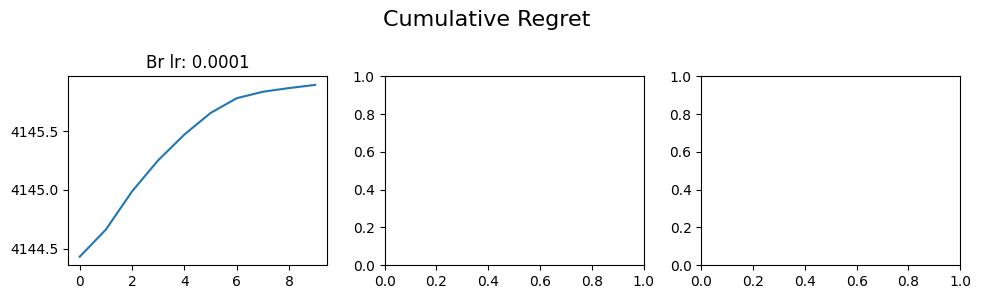

In [ ]:
plot_loss_dict(data_exp_cumul_regrets_leontief, "Cumulative Regret")

#### Exploitability Minimization

In [ ]:
# Initialize training parameters
eqm_lr_sweep = [1e-4, 1e-5, 1e-6]
br_lr_sweep = [1e-3, 1e-4, 1e-5]
exp_lr = 1e-3

# eqm_lr_sweep = [1e-5, 1e-6, 1e-7]
# br_lr_sweep = [1e-4, 1e-5, 1e-6]


num_samples = 1
num_epochs = 1000
num_epochs_exp = 1000
num_episodes = 30
print_iter = 200

data_cumul_regrets_leontief_gap = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_total_first_order_violations_leontief_gap = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_avg_excess_demand_leontief_gap = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_consumer_first_order_violations_leontief_gap = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_avg_bellman_error_leontief_gap = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_exploitabilities_leontief_gap = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
for eqm_lr, br_lr  in product(eqm_lr_sweep, br_lr_sweep):
    print(f"==================== Eqm. lr: {eqm_lr}, Br lr: {br_lr} ====================")

    (cumul_regrets, total_first_order_violations, avg_excess_demands, consumer_first_order_violations, avg_bellman_error), _, _, exploitabilities = exploitability_minimization(economy_leontief, eqm_lr, br_lr, exp_lr, num_epochs, num_epochs_exp, num_samples, num_episodes, print_iter = print_iter, compute_exploit=False)


    data_cumul_regrets_leontief_gap[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = cumul_regrets
    data_total_first_order_violations_leontief_gap[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = total_first_order_violations
    data_avg_excess_demand_leontief_gap[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = avg_excess_demands
    data_consumer_first_order_violations_leontief_gap[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = consumer_first_order_violations
    data_avg_bellman_error_leontief_gap[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = avg_bellman_error
    data_exploitabilities_leontief_gap[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = exploitabilities


==================== Eqm. lr: 0.0001, Br lr: 0.001 ====================
==================== Epoch 0 ====================
commod_price: [3.0909073  1.596725   0.08469583 0.15326257 0.25793642 0.3439559
 0.08950739 3.5168204  0.01347014 0.85271895], asset_price: [0.46220762], consumption: [[0.12324291 0.21449737 1.         1.         1.         0.9076921
  1.         0.05619843 1.         0.25429255]
 [0.11786543 0.22104715 1.         1.         1.         0.99999994
  1.         0.04911178 1.         0.231387  ]
 [0.13923962 0.2350003  1.         1.         1.         0.99999994
  1.         0.05480556 1.         0.2543939 ]
 [0.11573324 0.22683305 1.         1.         1.         0.96926945
  1.         0.05749206 1.         0.2577422 ]
 [0.12020957 0.2484656  1.         1.         1.         0.99999994
  1.         0.0501297  1.         0.2280064 ]
 [0.13121048 0.24728502 1.         1.         1.         0.99999994
  1.         0.05724195 1.         0.26838905]
 [0.12657273 0.2439755

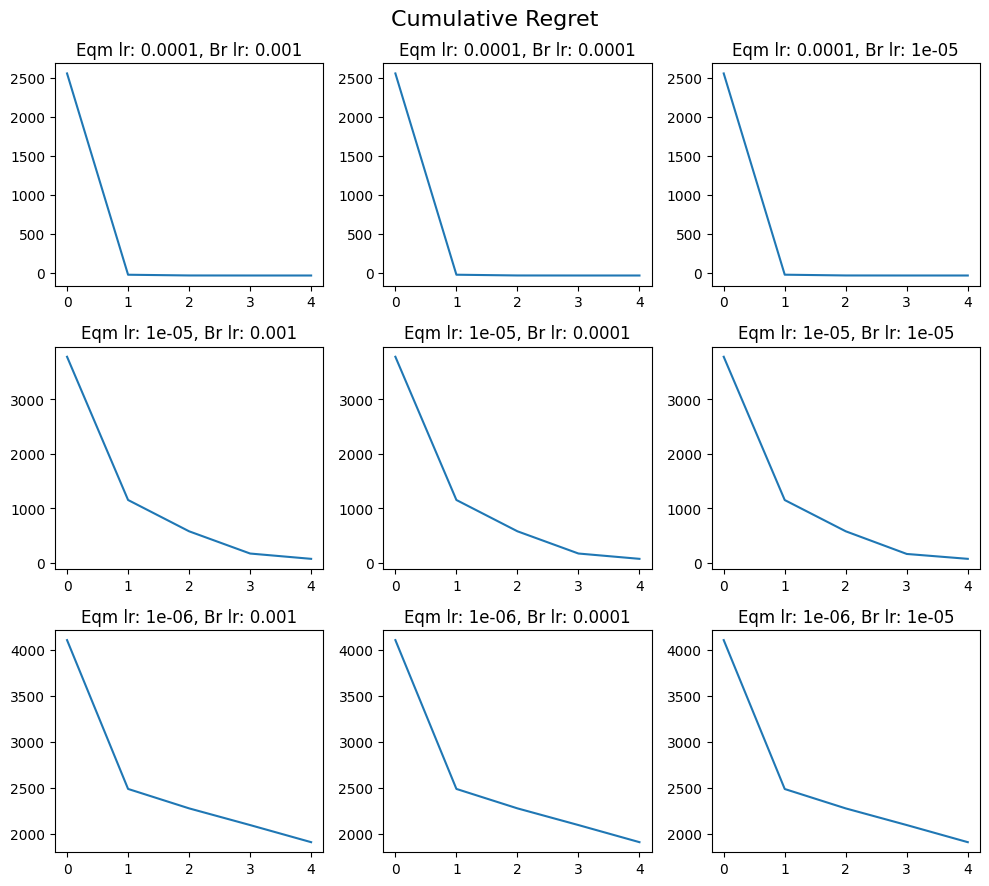

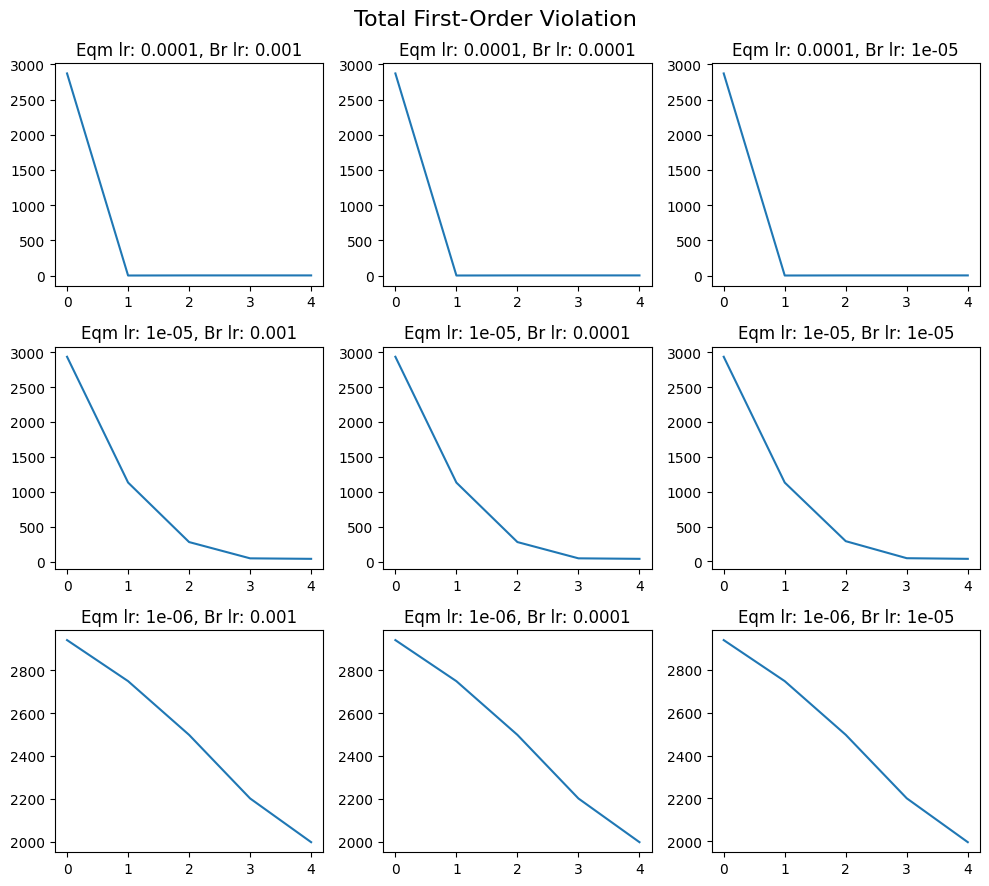

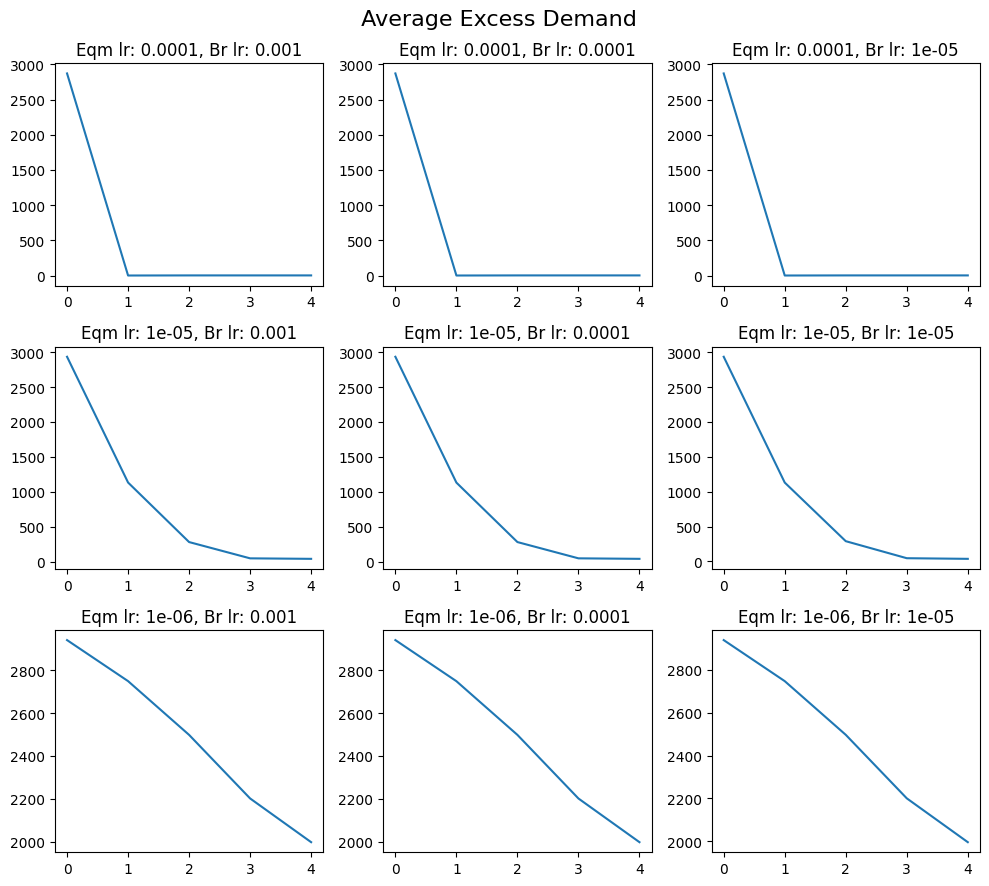

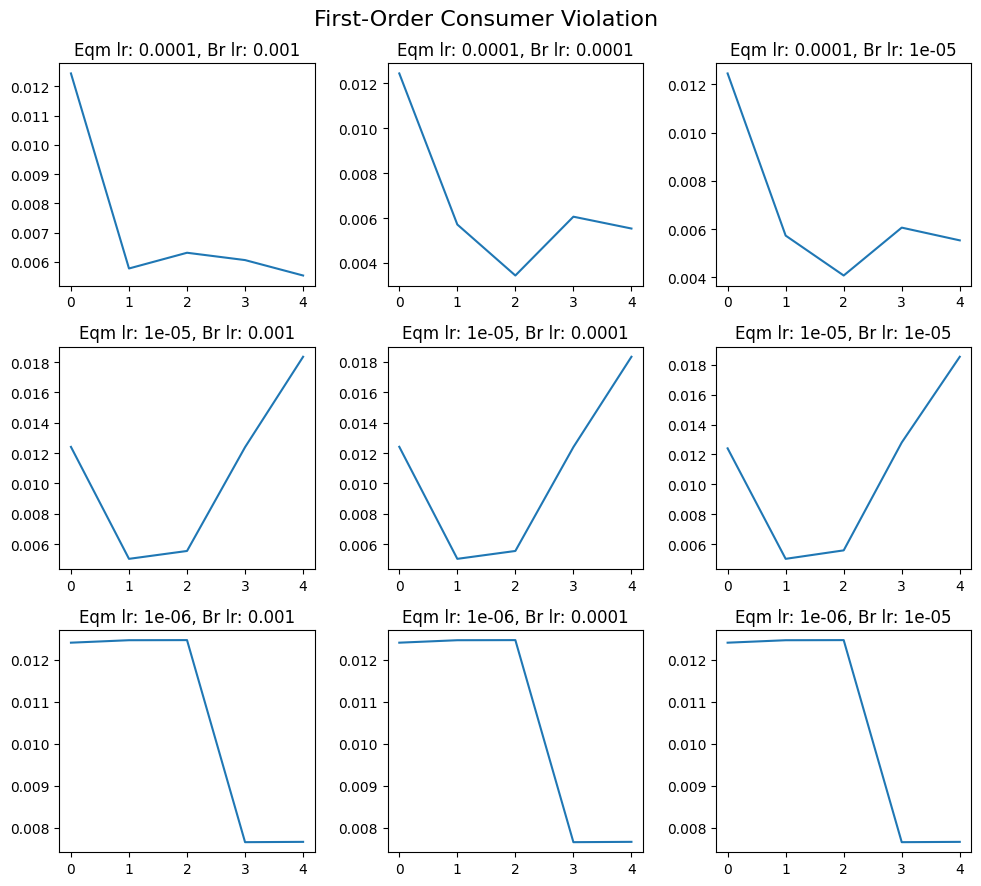

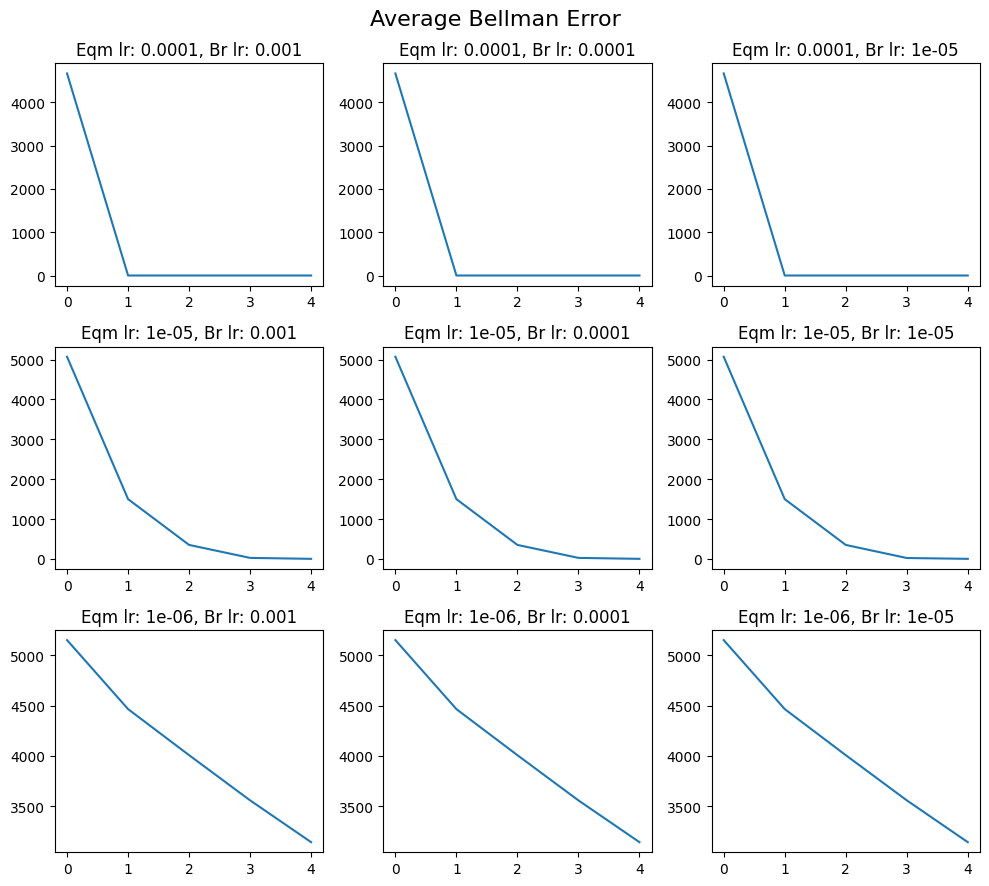

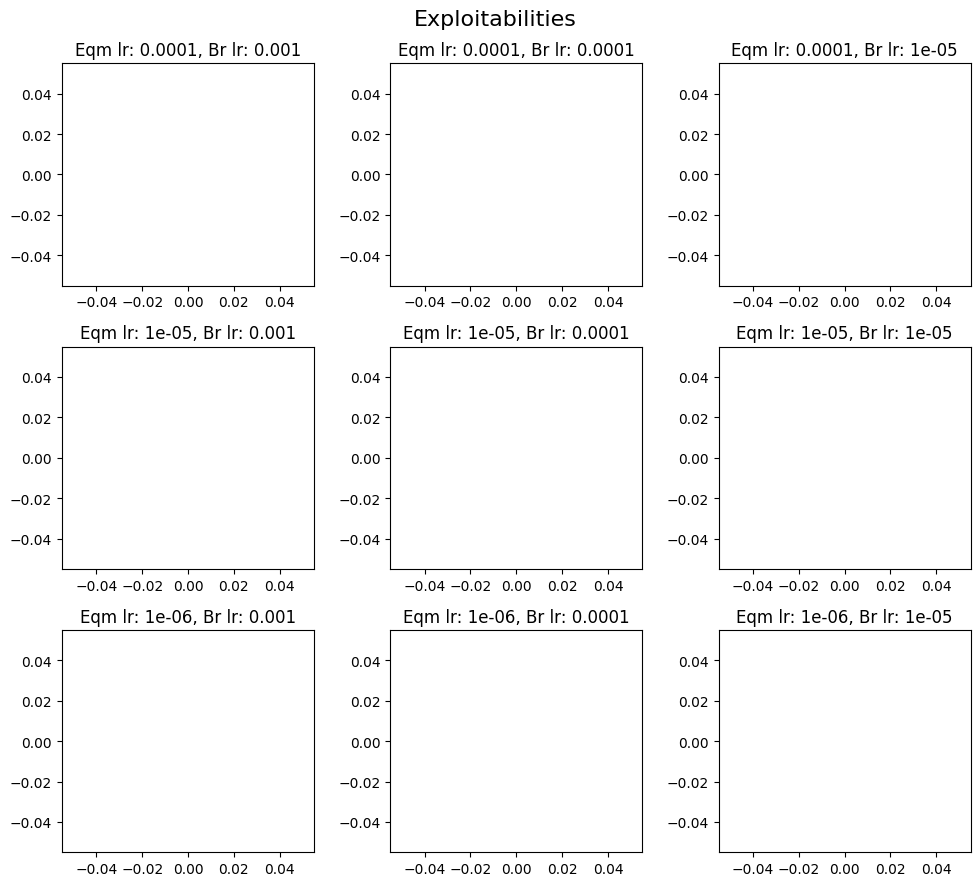

In [ ]:
plot_loss_dict(data_cumul_regrets_leontief_gap, "Cumulative Regret")
plot_loss_dict(data_total_first_order_violations_leontief_gap, "Total First-Order Violation")
plot_loss_dict(data_avg_excess_demand_leontief_gap, " Average Excess Demand")
plot_loss_dict(data_consumer_first_order_violations_leontief_gap, "First-Order Consumer Violation")
plot_loss_dict(data_avg_bellman_error_leontief_gap, "Average Bellman Error")
plot_loss_dict(data_exploitabilities_leontief_gap, "Exploitabilities")

#### Deep Equilibrium Nets

In [ ]:
# Initialize training parameters
eqm_lr_sweep = [5e-4, 1e-4]
balance_constant_sweep = [0.5]

num_samples = 1
num_epochs = 1000
num_episodes = 30
print_iter = 200





data_total_first_order_violations_leontief_npm = {f"Eqm lr: {eqm_lr}, Balance: {balance_const}": [] for eqm_lr, balance_const in product(eqm_lr_sweep, balance_constant_sweep)}
data_avg_excess_demand_leontief_npm = {f"Eqm lr: {eqm_lr}, Balance: {balance_const}": [] for eqm_lr, balance_const in product(eqm_lr_sweep, balance_constant_sweep)}
data_consumer_first_order_violations_leontief_npm = {f"Eqm lr: {eqm_lr}, Balance: {balance_const}": [] for eqm_lr, balance_const in product(eqm_lr_sweep, balance_constant_sweep)}
data_avg_bellman_error_leontief_npm = {f"Eqm lr: {eqm_lr}, Balance: {balance_const}": [] for eqm_lr, balance_const in product(eqm_lr_sweep, balance_constant_sweep)}
data_exploitabilities_leontief_npm = {f"Eqm lr: {eqm_lr}, Balance: {balance_const}": [] for eqm_lr, balance_const in product(eqm_lr_sweep, balance_constant_sweep)}
for eqm_lr, balance_const  in product(eqm_lr_sweep, balance_constant_sweep):
    print(f"==================== Eqm lr: {eqm_lr}, Balance: {balance_const} ====================")

    (total_first_order_violations, avg_excess_demands, consumer_first_order_violations, avg_bellman_errors), _, exploitabilities = neural_projection_method(economy_leontief, eqm_lr, exp_lr, balance_const, num_epochs, num_epochs_exp, num_samples, num_episodes, print_iter = print_iter, compute_exploit = False)


    data_total_first_order_violations_leontief_npm[f"Eqm lr: {eqm_lr}, Balance: {balance_const}"] = total_first_order_violations
    data_avg_excess_demand_leontief_npm[f"Eqm lr: {eqm_lr}, Balance: {balance_const}"] = avg_excess_demands
    data_consumer_first_order_violations_leontief_npm[f"Eqm lr: {eqm_lr}, Balance: {balance_const}"] = consumer_first_order_violations
    data_avg_bellman_error_leontief_npm[f"Eqm lr: {eqm_lr}, Balance: {balance_const}"] = avg_bellman_errors
    data_exploitabilities_leontief_npm[f"Eqm lr: {eqm_lr}, Balance: {balance_const}"] = exploitabilities



==================== Eqm lr: 0.0005, Balance: 0.5 ====================
==================== Epoch 0 ====================
Loss: 8102.8369140625
Average excess demand: 2940.514892578125
Consumer first order violation: 0.012406024150550365
avg bellman error: 5162.3095703125
==================== Epoch 200 ====================
Loss: 57.349365234375
Average excess demand: 17.474044799804688
Consumer first order violation: 0.008748527616262436
avg bellman error: 39.86656951904297
==================== Epoch 400 ====================
Loss: 18.665502548217773
Average excess demand: 16.915760040283203
Consumer first order violation: 0.018655534833669662
avg bellman error: 1.7310866117477417
==================== Epoch 600 ====================
Loss: 17.034175872802734
Average excess demand: 16.537193298339844
Consumer first order violation: 0.018969787284731865
avg bellman error: 0.47801145911216736
==================== Epoch 800 ====================
Loss: 16.631874084472656
Average excess demand: 1

In [ ]:
plot_loss_dict(data_total_first_order_violations_leontief_npm, "First-Order Violation")
plot_loss_dict(data_avg_excess_demand_leontief_npm, "Average Excess Demand")
plot_loss_dict(data_consumer_first_order_violations_leontief_npm, "Consumer First-Order Violation")
plot_loss_dict(data_avg_bellman_error_leontief_npm, "Average Bellman Error")
plot_loss_dict(data_exploitabilities_leontief_npm, "Exploitabilities")

NameError: name 'data_total_first_order_violations_leontief_npm' is not defined

### Final Experiment


In [ ]:
# Initialize training parameters
num_samples = 1
num_epochs = 2000
num_epochs_exp = 1000
num_episodes = 30
gap_lr = 1e-5
br_lr = 1e-5
npm_lr = 1e-4
exp_lr = 1e-4
balance_constant = 0.5
print_iter = 200

(data_cumul_regrets_leontief_gap, data_total_first_order_violations_leontief_gap, data_avg_excess_demand_leontief_gap, data_consumer_first_order_violations_leontief_gap, data_avg_bellman_error_leontief_gap), _, _, exploitabilities_gap = exploitability_minimization(economy_leontief, gap_lr, br_lr, exp_lr, num_epochs, num_epochs_exp, num_samples, num_episodes, print_iter = print_iter, compute_exploit = True)



(data_total_first_order_violations_leontief_npm, data_avg_excess_demand_leontief_npm, data_consumer_first_order_violations_leontief_npm, data_avg_bellman_error_leontief_npm), _, exploitabilities_npm  = neural_projection_method(economy_leontief, npm_lr, exp_lr, balance_constant, num_epochs, num_epochs_exp, num_samples, num_episodes, print_iter = print_iter, compute_exploit=True)


data_leontief = {"Total First Order Violation":       {"GAP": data_total_first_order_violations_leontief_gap,
                                                     "NPM": data_total_first_order_violations_leontief_npm},
                "Excess Demand Violation":          {"GAP": data_avg_excess_demand_leontief_gap,
                                                     "NPM": data_avg_excess_demand_leontief_npm},
                "Consumer First-Order Violation":   {"GAP": data_consumer_first_order_violations_leontief_gap,
                                                     "NPM": data_consumer_first_order_violations_leontief_npm},
                "Avg Bellman Error":                {"GAP": data_avg_bellman_error_leontief_gap,
                                                  "NPM": data_avg_bellman_error_leontief_npm},
               "Exploitability":                   {"GAP": exploitabilities_gap,
                                                     "NPM": exploitabilities_npm}

               }


folder_name = "data"
os.makedirs(folder_name, exist_ok=True)

# Save the dictionaries as files inside the folder
data_leontief_file = os.path.join(folder_name, "data_leontief.pkl")

# Save the dictionaries as files
with open(data_leontief_file, "wb") as f:
    pickle.dump(data_leontief, f)

==================== Epoch 0 ====================
commod_price: [3.0574384  1.5893903  0.08967575 0.16537783 0.27463073 0.35172895
 0.091662   3.479982   0.01519521 0.88491964], asset_price: [0.4699654], consumption: [[0.12688838 0.21782269 1.         1.         1.         0.9144936
  1.         0.05956556 1.         0.25290638]
 [0.12212244 0.22553632 1.         1.         1.         0.99999994
  1.         0.05245987 1.         0.23053555]
 [0.14157006 0.24110684 1.         1.         1.         0.99999994
  1.         0.05761633 1.         0.25244176]
 [0.11885073 0.23045607 1.         1.         1.         0.9788026
  1.         0.06068336 1.         0.25597408]
 [0.12325419 0.25498265 1.         1.         1.         0.99999994
  1.         0.05299134 1.         0.2271944 ]
 [0.13508536 0.2509512  1.         1.         1.         0.99999994
  1.         0.06056243 1.         0.26546645]
 [0.1288234  0.24886122 1.         1.         1.         0.99999994
  1.         0.05364265 1. 

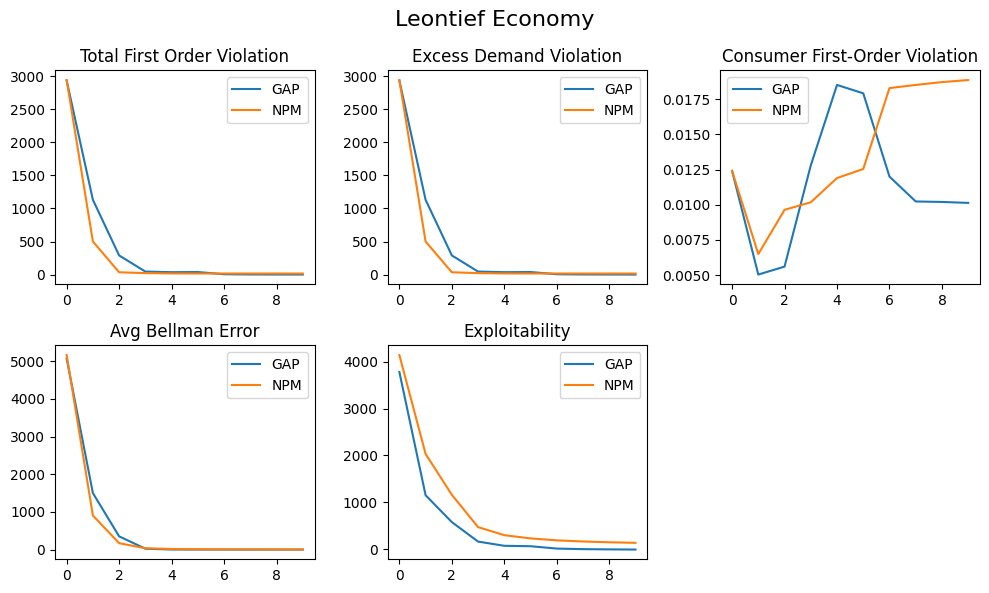

In [ ]:
plot_loss_overlay_dict(data_leontief, "Leontief Economy")

### Normalization

In [ ]:
num_samples_normal = 20
prng = hk.PRNGSequence(SEED)
num_samples = 1
num_epochs = 2000
num_epochs_exp = 1000
num_episodes = 30
gap_lr = 1e-5
br_lr = 1e-5
npm_lr = 1e-4
exp_lr = 1e-4
print_iter = 200

excess_demand_violations = []
consumer_first_order_violations = []
total_first_order_violations = []
avg_bellman_errors = []
exploitabilities = []
economy = economy_leontief

for i in range(num_samples_normal):
    print(f"----------------------------------------Sample {i}-----------------------------------------")
    eqm_network = hk.without_apply_rng(hk.transform(_eqm_network))
    eqm_params = eqm_network.init(next(prng), economy_leontief.get_initial_state(next(prng)), economy_leontief)
    eqm_generator = Policy(eqm_network, eqm_params)
    eqm_policy = lambda s: eqm_generator(s, economy)

    excess_demand_violation = EconomySimulator.estimate_first_order_seller_violation(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore
    consumer_first_order_violation = EconomySimulator.estimate_first_order_consumer_violation(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore
    total_first_order_loss = excess_demand_violation + consumer_first_order_violation #type: ignore
    avg_bellman_error = EconomySimulator.estimate_avg_bellman_error(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore
    exploitability, br_policy = compute_exploitability(economy, eqm_params, exp_lr, num_epochs_exp, num_samples, num_episodes, print_iter=print_iter)
    if not (jnp.isnan(jnp.array(excess_demand_violation)) or jnp.isnan(jnp.array(consumer_first_order_violation)) or jnp.isnan(jnp.array(avg_bellman_error)) or jnp.isnan(jnp.array(exploitability[-1]))):
      print(excess_demand_violation)
      print(consumer_first_order_violation)
      print(avg_bellman_error)
      print("There is no nan! Store it.")
      excess_demand_violations.append(excess_demand_violation)
      consumer_first_order_violations.append(consumer_first_order_violation)
      total_first_order_violations.append(total_first_order_loss)
      avg_bellman_errors.append(avg_bellman_error)
      exploitabilities.append(exploitability[-1])



----------------------------------------Sample 0-----------------------------------------
==================== Epoch 0 ====================
Cumulative Regret: 4144.423828125
==================== Epoch 200 ====================
Cumulative Regret: 4144.97998046875
==================== Epoch 400 ====================
Cumulative Regret: 4145.46435546875
==================== Epoch 600 ====================
Cumulative Regret: 4145.7744140625
==================== Epoch 800 ====================
Cumulative Regret: 4145.86083984375
2940.515
0.012406024
5162.14
There is no nan! Store it.
----------------------------------------Sample 1-----------------------------------------
==================== Epoch 0 ====================
Cumulative Regret: 25173.515625
==================== Epoch 200 ====================
Cumulative Regret: 25174.177734375
==================== Epoch 400 ====================
Cumulative Regret: 25175.380859375
==================== Epoch 600 ====================
Cumulative Regret: 25

In [ ]:
avg_excess_demand_violation = np.mean(excess_demand_violations)
avg_consumer_first_order_violation = np.mean(consumer_first_order_violations)
avg_total_first_order_loss = np.mean(total_first_order_loss)
avg_avg_bellman_error = np.mean(np.clip(avg_bellman_errors, a_min=1e-20, a_max=1e6))
avg_exploitability = np.mean(np.clip(exploitabilities, a_min=1e-20, a_max=1e6))

normal_data_leontief = {"Total First Order Violation":      total_first_order_loss,
                   "Excess Demand Violation":          excess_demand_violations,
                   "Consumer First-Order Violation":   consumer_first_order_violations,
                   "Avg Bellman Error":                avg_bellman_errors,
                   "Exploitability":                   exploitabilities}


avg_data_leontief = {"Total First Order Violation":      avg_total_first_order_loss,
                   "Excess Demand Violation":          avg_excess_demand_violation,
                   "Consumer First-Order Violation":   avg_consumer_first_order_violation,
                   "Avg Bellman Error":                avg_avg_bellman_error,
                   "Exploitability":                   avg_exploitability}

folder_name = "data"
os.makedirs(folder_name, exist_ok=True)

# Save the dictionaries as files inside the folder
avg_data_leontief_file = os.path.join(folder_name, "avg_data_leontief.pkl")
normal_data_leontief_file = os.path.join(folder_name, "normal_data_leontief.pkl")

# Save the dictionaries as files
with open(avg_data_leontief_file, "wb") as f:
    pickle.dump(avg_data_leontief, f)
    pickle.dump(normal_data_leontief, f)

# print(avg_data_leontief["Excess Demand Violation"])

In [ ]:
# prompt: Normalize each data entry in data_leontief by the average value in avg_data_leontief

import pickle

# Load the data
with open("data/data_leontief.pkl", "rb") as f:
    data_leontief = pickle.load(f)

# Load the average data
with open("data/avg_data_leontief.pkl", "rb") as f:
    avg_data_leontief = pickle.load(f)

# Normalize the data
normalized_data_leontief = {}
for key, value in data_leontief.items():
    normalized_data_leontief[key] = {}
    for subkey, subvalue in value.items():
        normalized_data_leontief[key][subkey] = np.array(subvalue) / avg_data_leontief[key]



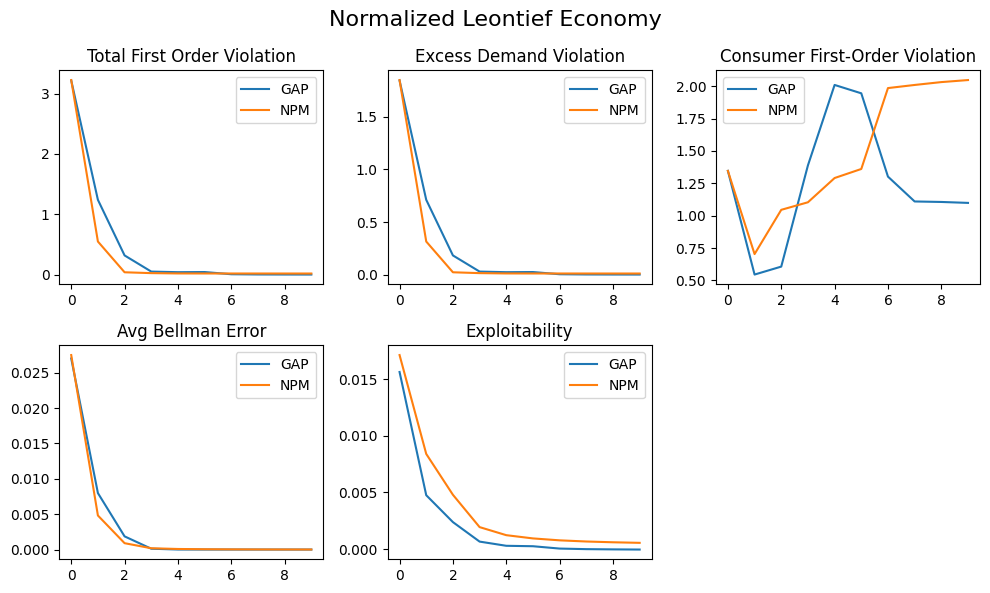

In [ ]:
plot_loss_overlay_dict(normalized_data_leontief, "Normalized Leontief Economy")

### Exp 3

In [ ]:
three_normalized_data_leontief = {"Total First Order Violation":      normalized_data_leontief["Total First Order Violation"],
                   "Avg Bellman Error":                normalized_data_leontief["Avg Bellman Error"],
                   "Exploitability":                  normalized_data_leontief["Exploitability"]}

one_normalized_data_leontief = {"Exploitability":                  normalized_data_leontief["Exploitability"]}


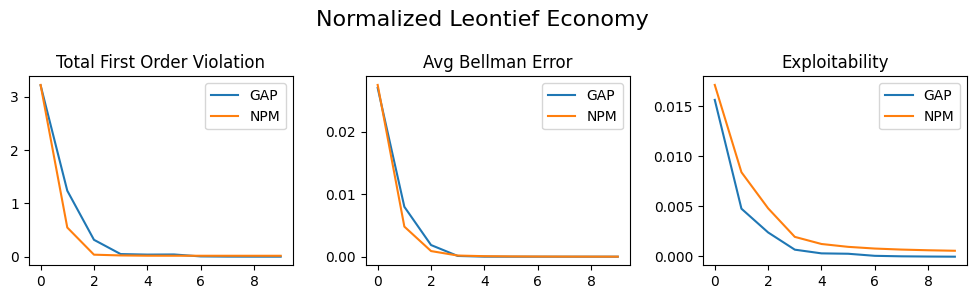

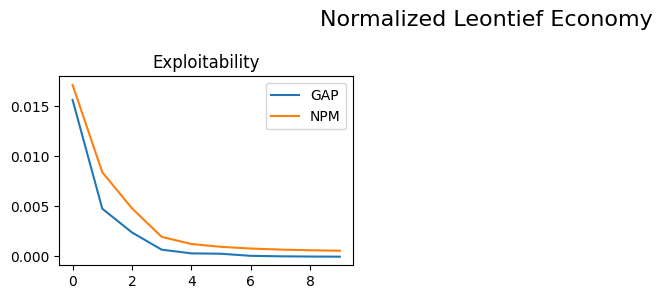

In [ ]:
plot_loss_overlay_dict(three_normalized_data_leontief, "Normalized Leontief Economy")
plot_loss_overlay_dict(one_normalized_data_leontief, "Normalized Leontief Economy")

In [ ]:
# pyright: reportPrivateImportUsage = none

# Market parameters
key = jax.random.PRNGKey(SEED)

max_supply = 1.0
commod_price_sum_space = 10.0
num_consumers = 10
num_commods = 10
num_assets = 1
num_world_states = 5
util_type = "Leontief"
discount = 0.9
consumer_endow_range = (0.1*max_supply/(num_consumers), max_supply/(num_consumers))
consumer_type_range = (1.0, 5.0)
asset_return_range = (0.5, 1.1)
asset_price_range = (ZERO_CLIP_MIN, max_supply)
portfolio_range = (-commod_price_sum_space, commod_price_sum_space)


asset_return = jax.random.uniform(key, shape=(num_world_states, num_assets, num_commods), minval = asset_return_range[0], maxval = asset_return_range[1])

world_state_probs = (1/num_world_states)*jnp.ones(num_world_states)
income_rate = jnp.ones(num_consumers*num_commods).reshape(num_consumers, num_commods)/(num_consumers*num_commods)*0.2

@jax.jit
def transition_function(economy: MarkovEconomy, state: State, consumption: jnp.ndarray, portfolio: jnp.ndarray, key: jax.random.PRNGKey) -> State:
    key, subkey = jax.random.split(key)
    world_state = state.world_state

    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets

    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range

    consumer_endow = state.spot_market.consumer_endow
    consumer_type = state.spot_market.consumer_type

    # Get next world state
    next_world_state = jax.random.choice(key, jnp.arange(num_world_states), p = world_state_probs)
    # next_world_state =  0

    # Get next consumer endowments
    next_consumer_endow = income_rate + jax.random.uniform(subkey, shape=(num_consumers, num_commods), minval = consumer_endow_range[0], maxval = consumer_endow_range[1])
    # next_consumer_endow = jnp.ones((num_consumers, num_commods))*consumer_endow_range[0]
    next_consumer_endow = jnp.clip(next_consumer_endow, consumer_endow_range[0], consumer_endow_range[1])

    # Get next consumer types
    next_consumer_type = consumer_type
    next_consumer_type = jax.tree_util.tree_map( lambda x: jnp.clip(x, consumer_type_range[0], consumer_type_range[1]), consumer_type)

    return state.replace_state(next_world_state, consumer_endow = next_consumer_endow, consumer_type = next_consumer_type)

@jax.jit
def init_state_function(economy: MarkovEconomy, key: jax.random.PRNGKey) -> State:
    # key, subkey = jax.random.split(key)
    key, subkey = jax.random.split(jax.random.PRNGKey(SEED))

    num_world_states = economy.num_world_states
    num_consumers = economy.num_consumers
    num_commods = economy.num_commods
    num_assets = economy.num_assets

    consumer_endow_range = economy.consumer_endow_range
    consumer_type_range = economy.consumer_type_range
    asset_return_range = economy.asset_return_range

    init_world_state = jnp.array(0) # jax.random.choice(key, jnp.arange(num_world_states, dtype = int), p = world_state_probs)

    # Get next consumer endowments
    init_consumer_endow = jax.random.uniform(key, shape=(num_consumers, num_commods), minval = consumer_endow_range[0], maxval = consumer_endow_range[1])
    init_consumer_endow = init_consumer_endow / jnp.sum(init_consumer_endow, axis = 0, keepdims= True)

    # Get next consumer types
    init_consumer_valuation = jax.random.uniform(subkey, shape=(num_consumers, num_commods), minval = consumer_type_range[0], maxval = consumer_type_range[1])
    init_consumer_type = {
        "valuation": init_consumer_valuation
    }

    return State(init_world_state, SpotMarket(init_consumer_endow, init_consumer_type))


economy_leontief = MarkovEconomy(num_consumers, num_commods, num_assets, num_world_states, UtilityFunction(util_type), asset_return, transition_function, discount, init_state_function, consumer_endow_range, consumer_type_range, asset_return_range, commod_price_sum_space, asset_price_range, portfolio_range)


### Hyperparameter search

#### Compute Exploitability

In [ ]:
br_lr_sweep = [1e-4]
num_samples = 100
num_epochs = 1000
num_episodes = 30
print_iter = 100

prng = hk.PRNGSequence(SEED)
eqm_network = hk.without_apply_rng(hk.transform(_eqm_network))
eqm_params = eqm_network.init(next(prng), economy_leontief.get_initial_state(next(prng)), economy_leontief)

data_exp_cumul_regrets_leontief = {f"Br lr: {br_lr}": [] for br_lr in br_lr_sweep}
for br_lr in br_lr_sweep:
    print(f"==================== EBr lr: {br_lr} ====================")
    cumul_regrets, br_policy = compute_exploitability(economy_leontief, eqm_params, br_lr, num_epochs, num_samples, num_episodes, print_iter=print_iter)
    data_exp_cumul_regrets_leontief[f"Br lr: {br_lr}"] = cumul_regrets

==================== EBr lr: 0.0001 ====================
==================== Epoch 0 ====================
Cumulative Regret: 10972.978515625
==================== Epoch 100 ====================
Cumulative Regret: 11274.7216796875
==================== Epoch 200 ====================
Cumulative Regret: 11002.69140625
==================== Epoch 300 ====================
Cumulative Regret: 11111.0693359375
==================== Epoch 400 ====================
Cumulative Regret: 11056.8740234375
==================== Epoch 500 ====================
Cumulative Regret: 11013.2529296875
==================== Epoch 600 ====================
Cumulative Regret: 11014.42578125
==================== Epoch 700 ====================
Cumulative Regret: 11002.8486328125
==================== Epoch 800 ====================
Cumulative Regret: 11365.8798828125
==================== Epoch 900 ====================
Cumulative Regret: 10863.9609375


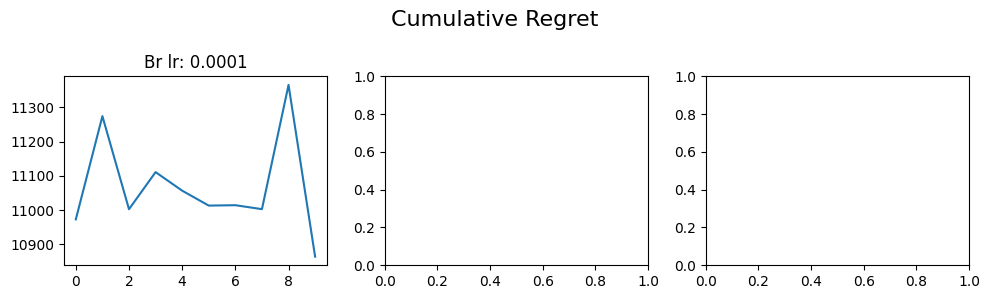

In [ ]:
plot_loss_dict(data_exp_cumul_regrets_leontief, "Cumulative Regret")

#### Exploitability Minimization

In [ ]:
# Initialize training parameters
eqm_lr_sweep = [1e-4, 1e-5, 1e-6]
br_lr_sweep = [1e-3, 1e-4, 1e-5]
exp_lr = 1e-3

# eqm_lr_sweep = [1e-5, 1e-6, 1e-7]
# br_lr_sweep = [1e-4, 1e-5, 1e-6]


num_samples = 100
num_epochs = 1000
num_epochs_exp = 1000
num_episodes = 30
print_iter = 200

data_cumul_regrets_leontief_gap = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_total_first_order_violations_leontief_gap = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_avg_excess_demand_leontief_gap = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_consumer_first_order_violations_leontief_gap = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_avg_bellman_error_leontief_gap = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
data_exploitabilities_leontief_gap = {f"Eqm lr: {eqm_lr}, Br lr: {br_lr}": [] for eqm_lr, br_lr in product(eqm_lr_sweep, br_lr_sweep)}
for eqm_lr, br_lr  in product(eqm_lr_sweep, br_lr_sweep):
    print(f"==================== Eqm. lr: {eqm_lr}, Br lr: {br_lr} ====================")

    (cumul_regrets, total_first_order_violations, avg_excess_demands, consumer_first_order_violations, avg_bellman_error), _, _, exploitabilities = exploitability_minimization(economy_leontief, eqm_lr, br_lr, exp_lr, num_epochs, num_epochs_exp, num_samples, num_episodes, print_iter = print_iter, compute_exploit=False)


    data_cumul_regrets_leontief_gap[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = cumul_regrets
    data_total_first_order_violations_leontief_gap[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = total_first_order_violations
    data_avg_excess_demand_leontief_gap[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = avg_excess_demands
    data_consumer_first_order_violations_leontief_gap[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = consumer_first_order_violations
    data_avg_bellman_error_leontief_gap[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = avg_bellman_error
    data_exploitabilities_leontief_gap[f"Eqm lr: {eqm_lr}, Br lr: {br_lr}"] = exploitabilities


==================== Eqm. lr: 0.0001, Br lr: 0.001 ====================
==================== Epoch 0 ====================
commod_price: [3.0322149  1.683874   0.10016925 0.17704584 0.2797513  0.37063253
 0.10344621 3.286923   0.01673248 0.9492099 ], asset_price: [0.4660748], consumption: [[0.12280765 0.19996537 1.         1.         1.         0.8239661
  1.         0.0615397  1.         0.23131655]
 [0.11905266 0.20867798 1.         1.         1.         0.99999994
  1.         0.05438974 1.         0.21274011]
 [0.13876018 0.22027378 1.         1.         1.         0.99999994
  1.         0.06011104 1.         0.23198107]
 [0.11483577 0.21050787 1.         1.         1.         0.8784113
  1.         0.06262105 1.         0.23328997]
 [0.11931697 0.23183377 1.         1.         1.         0.9902875
  1.         0.05458127 1.         0.20667301]
 [0.130625   0.23083115 1.         1.         1.         0.99999994
  1.         0.06266585 1.         0.24405447]
 [0.12497904 0.22691959 

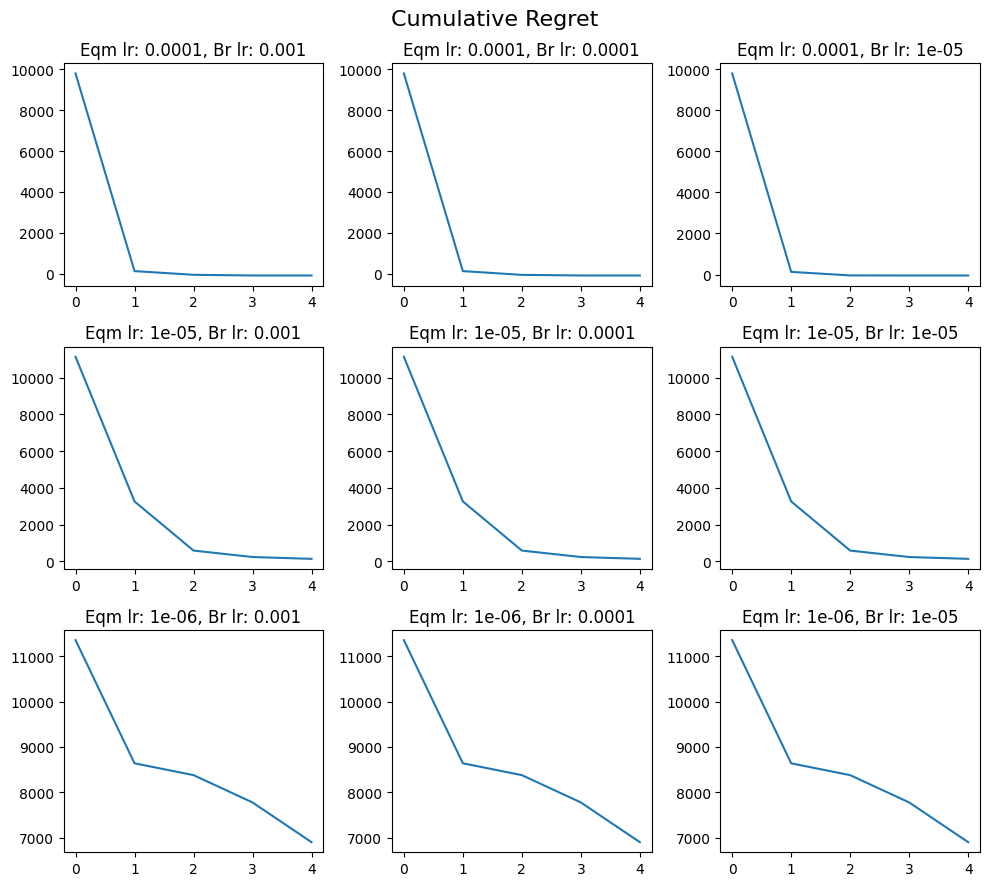

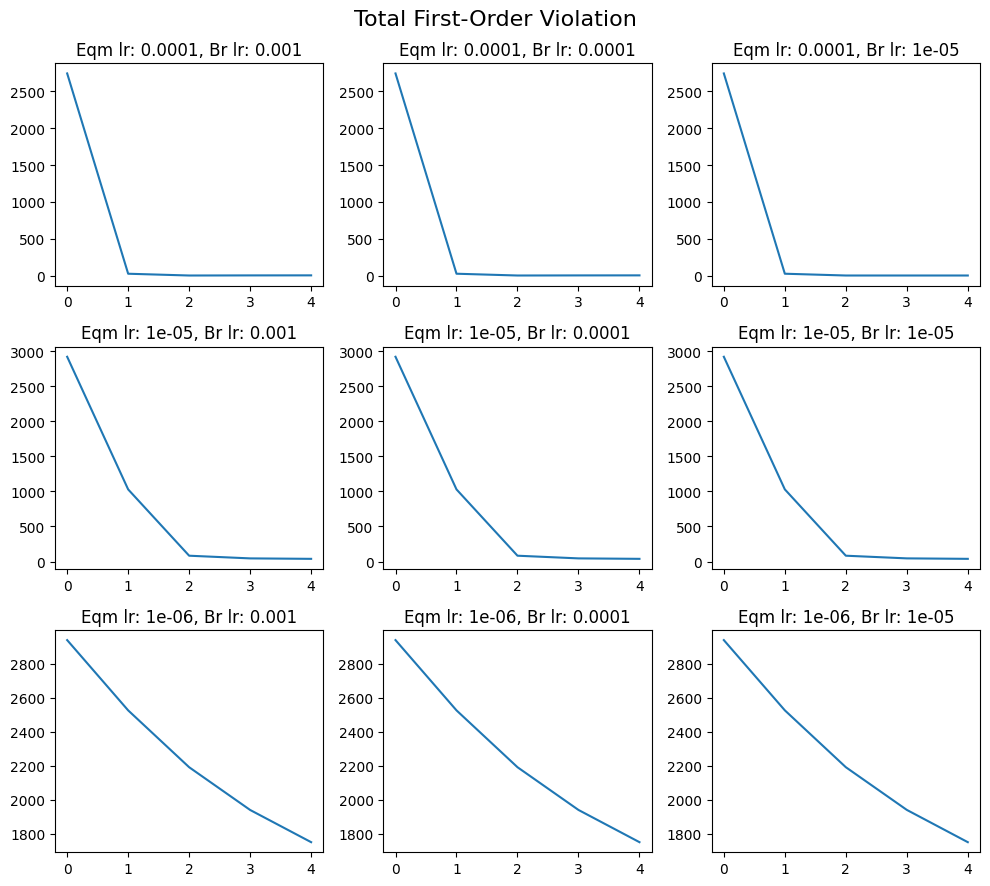

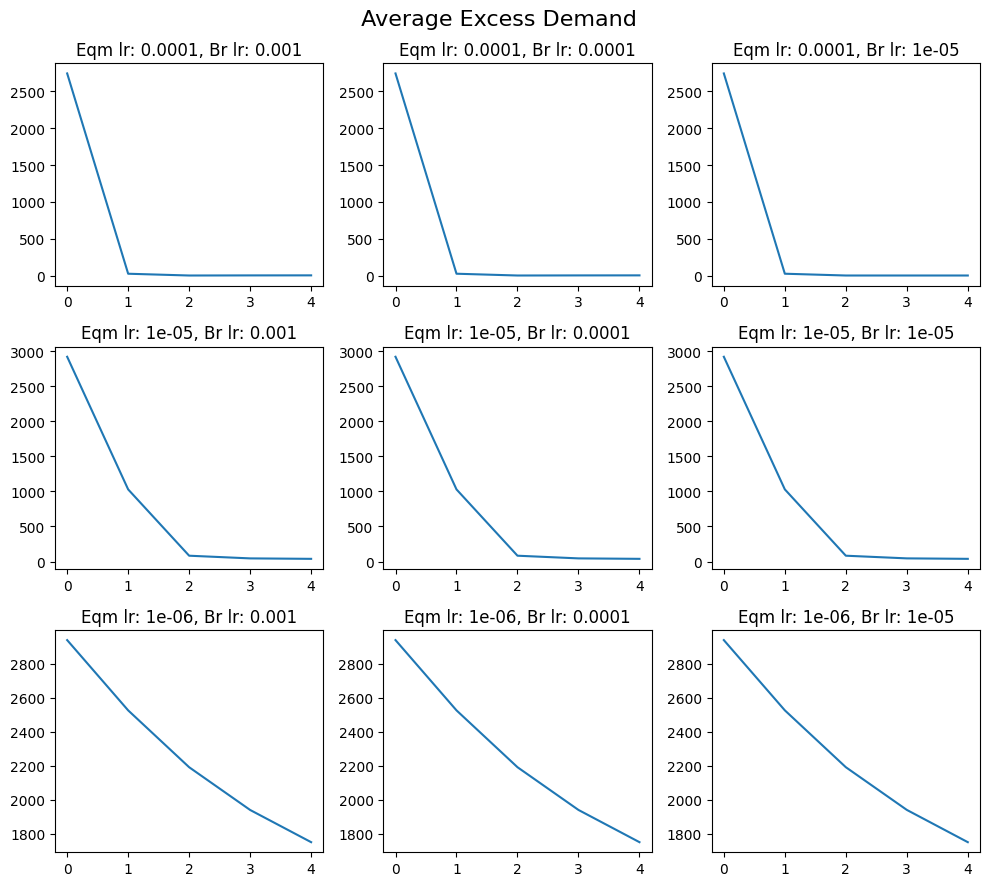

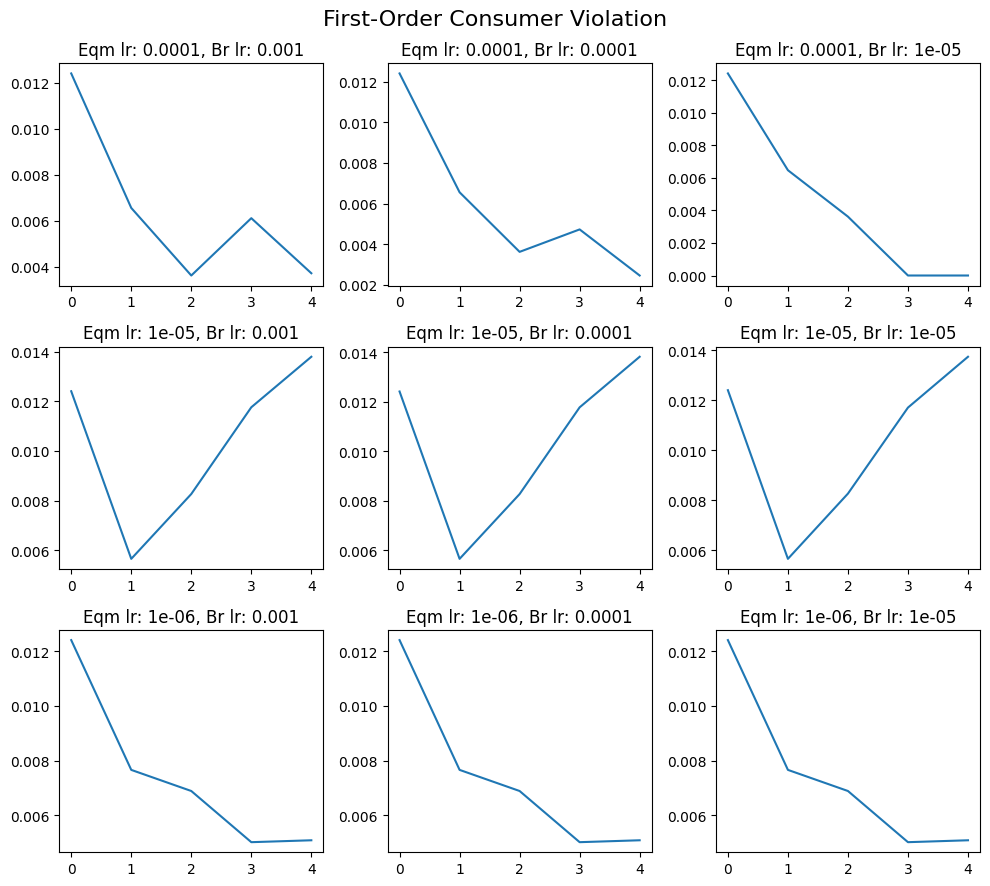

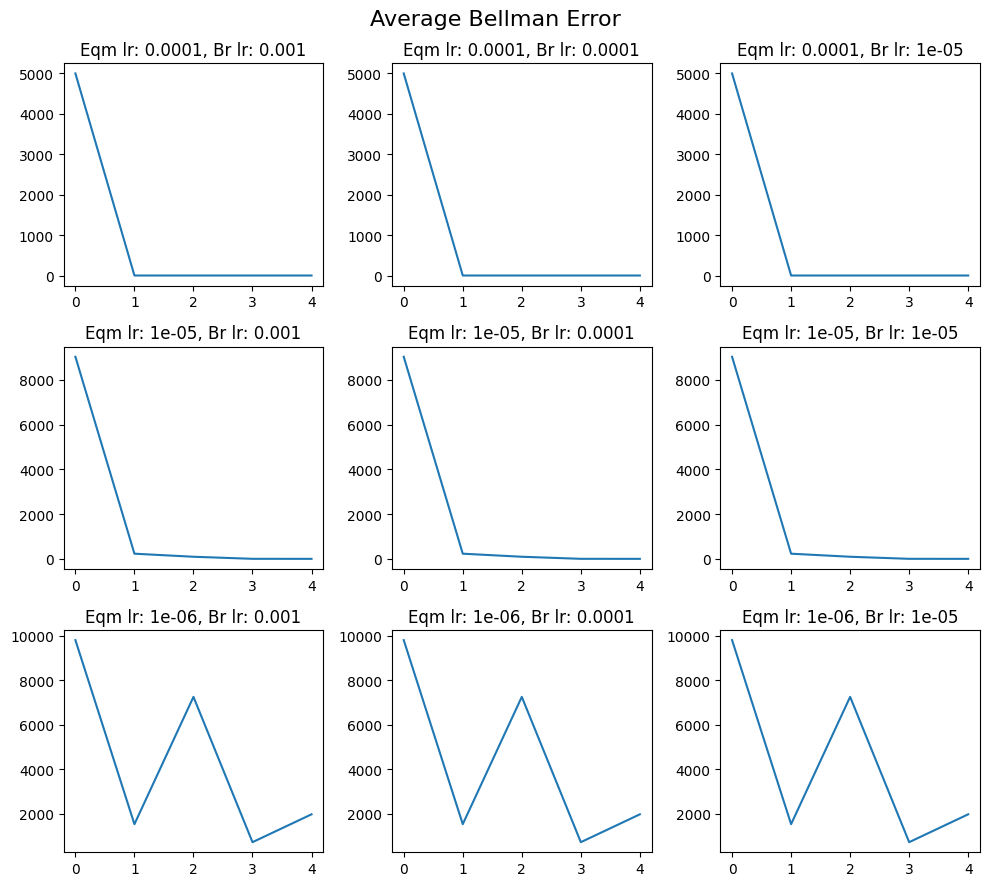

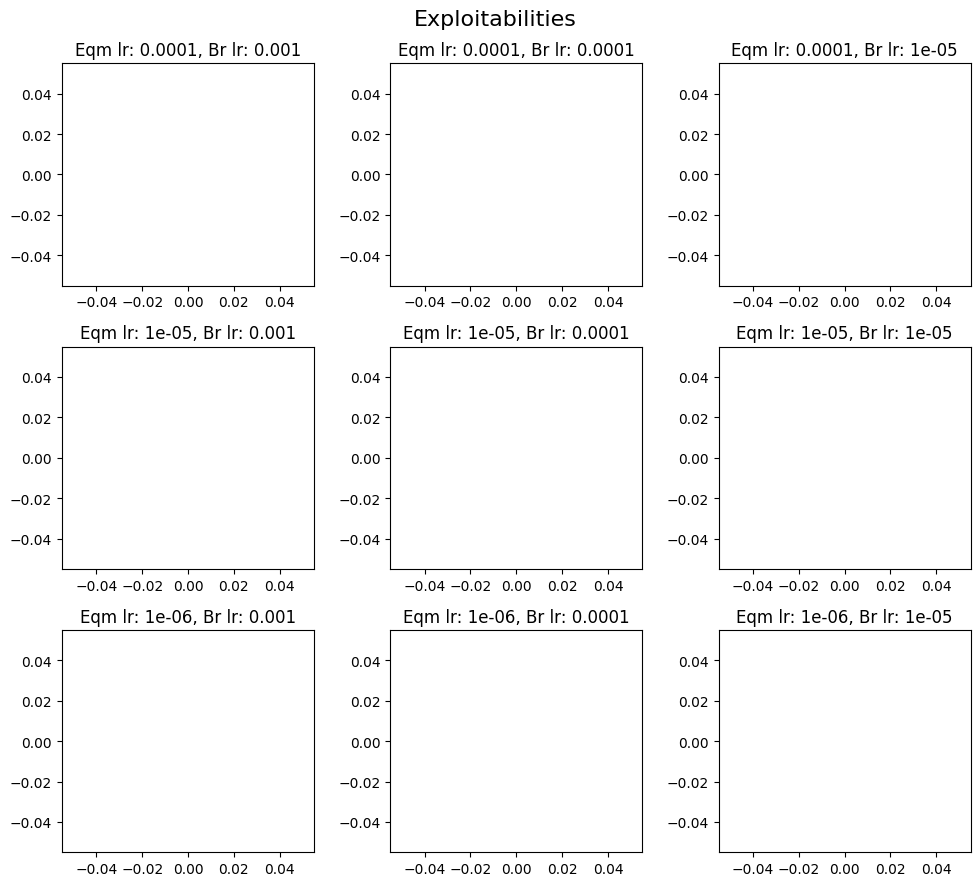

In [ ]:
plot_loss_dict(data_cumul_regrets_leontief_gap, "Cumulative Regret")
plot_loss_dict(data_total_first_order_violations_leontief_gap, "Total First-Order Violation")
plot_loss_dict(data_avg_excess_demand_leontief_gap, " Average Excess Demand")
plot_loss_dict(data_consumer_first_order_violations_leontief_gap, "First-Order Consumer Violation")
plot_loss_dict(data_avg_bellman_error_leontief_gap, "Average Bellman Error")
plot_loss_dict(data_exploitabilities_leontief_gap, "Exploitabilities")

#### Deep Equilibrium Nets

In [ ]:
# Initialize training parameters
eqm_lr_sweep = [5e-4, 1e-4]
balance_constant_sweep = [0.5]

num_samples = 10
num_epochs = 1000
num_episodes = 30
print_iter = 200





data_total_first_order_violations_leontief_npm = {f"Eqm lr: {eqm_lr}, Balance: {balance_const}": [] for eqm_lr, balance_const in product(eqm_lr_sweep, balance_constant_sweep)}
data_avg_excess_demand_leontief_npm = {f"Eqm lr: {eqm_lr}, Balance: {balance_const}": [] for eqm_lr, balance_const in product(eqm_lr_sweep, balance_constant_sweep)}
data_consumer_first_order_violations_leontief_npm = {f"Eqm lr: {eqm_lr}, Balance: {balance_const}": [] for eqm_lr, balance_const in product(eqm_lr_sweep, balance_constant_sweep)}
data_avg_bellman_error_leontief_npm = {f"Eqm lr: {eqm_lr}, Balance: {balance_const}": [] for eqm_lr, balance_const in product(eqm_lr_sweep, balance_constant_sweep)}
data_exploitabilities_leontief_npm = {f"Eqm lr: {eqm_lr}, Balance: {balance_const}": [] for eqm_lr, balance_const in product(eqm_lr_sweep, balance_constant_sweep)}
for eqm_lr, balance_const  in product(eqm_lr_sweep, balance_constant_sweep):
    print(f"==================== Eqm lr: {eqm_lr}, Balance: {balance_const} ====================")

    (total_first_order_violations, avg_excess_demands, consumer_first_order_violations, avg_bellman_errors), _, exploitabilities = neural_projection_method(economy_leontief, eqm_lr, exp_lr, balance_const, num_epochs, num_epochs_exp, num_samples, num_episodes, print_iter = print_iter, compute_exploit = False)


    data_total_first_order_violations_leontief_npm[f"Eqm lr: {eqm_lr}, Balance: {balance_const}"] = total_first_order_violations
    data_avg_excess_demand_leontief_npm[f"Eqm lr: {eqm_lr}, Balance: {balance_const}"] = avg_excess_demands
    data_consumer_first_order_violations_leontief_npm[f"Eqm lr: {eqm_lr}, Balance: {balance_const}"] = consumer_first_order_violations
    data_avg_bellman_error_leontief_npm[f"Eqm lr: {eqm_lr}, Balance: {balance_const}"] = avg_bellman_errors
    data_exploitabilities_leontief_npm[f"Eqm lr: {eqm_lr}, Balance: {balance_const}"] = exploitabilities



==================== Eqm lr: 0.0005, Balance: 0.5 ====================
==================== Epoch 0 ====================
Loss: 296653.0625
Average excess demand: 2940.515380859375
Consumer first order violation: 0.01240602321922779
avg bellman error: 293712.53125
==================== Epoch 200 ====================
Loss: 2262.725341796875
Average excess demand: 482.98248291015625
Consumer first order violation: 0.012054027058184147
avg bellman error: 1779.730712890625
==================== Epoch 400 ====================
Loss: 2065.383056640625
Average excess demand: 176.70469665527344
Consumer first order violation: 0.006195385009050369
avg bellman error: 1888.672119140625
==================== Epoch 600 ====================
Loss: 374.5603942871094
Average excess demand: 128.38450622558594
Consumer first order violation: 0.006718573160469532
avg bellman error: 246.16917419433594
==================== Epoch 800 ====================
Loss: 281.6822509765625
Average excess demand: 48.443004608

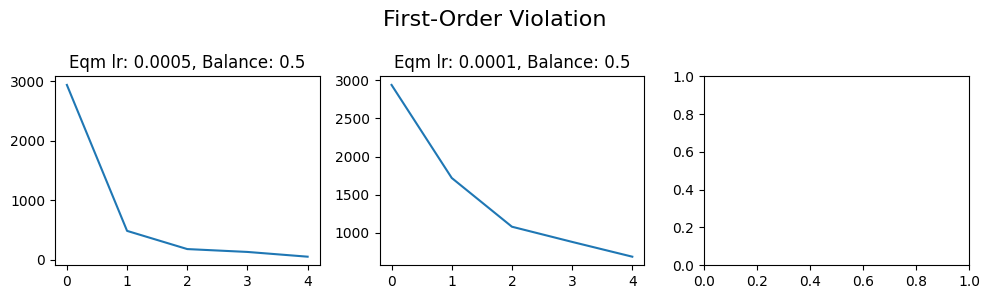

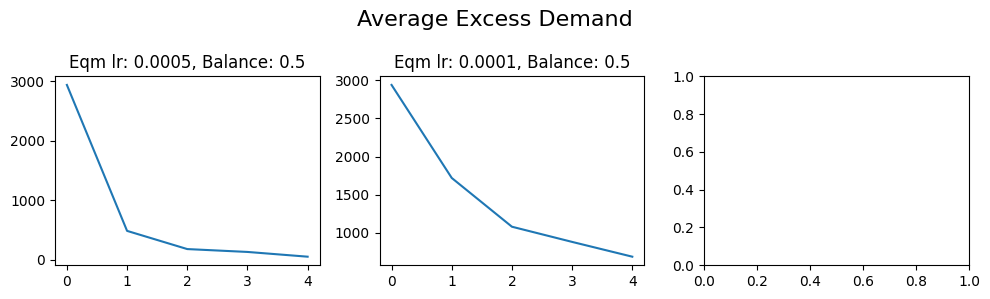

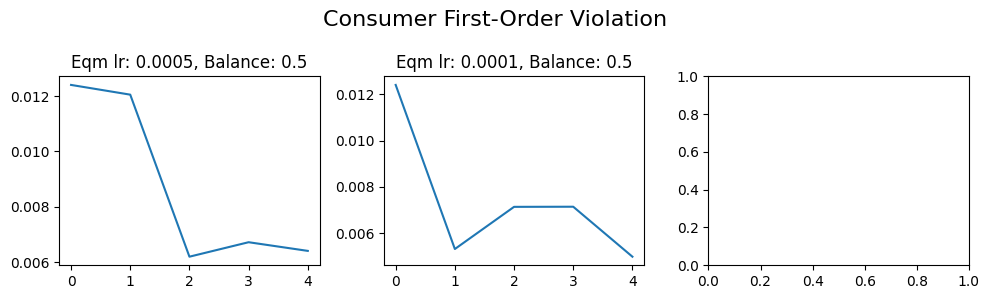

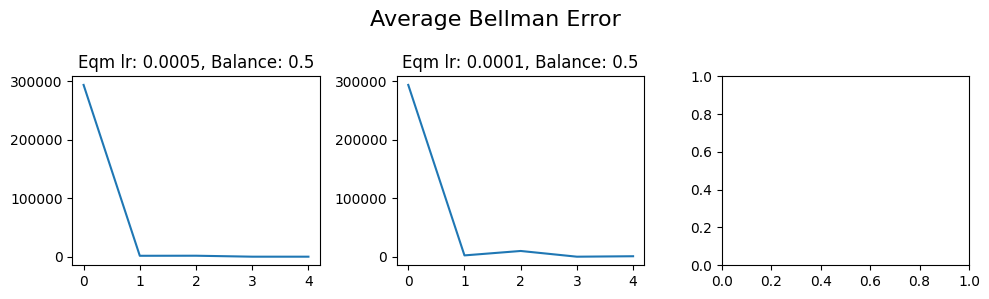

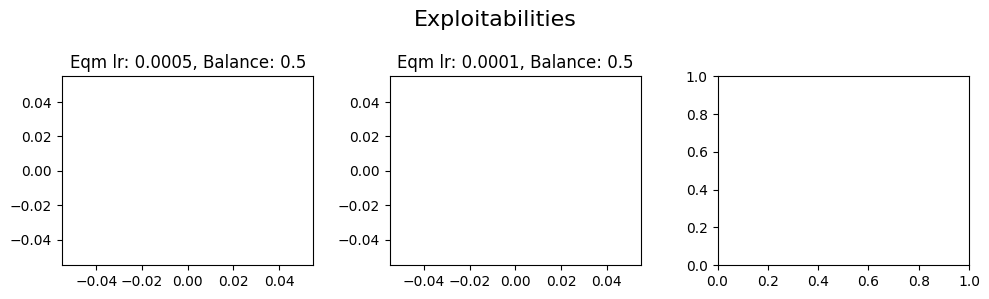

In [ ]:
plot_loss_dict(data_total_first_order_violations_leontief_npm, "First-Order Violation")
plot_loss_dict(data_avg_excess_demand_leontief_npm, "Average Excess Demand")
plot_loss_dict(data_consumer_first_order_violations_leontief_npm, "Consumer First-Order Violation")
plot_loss_dict(data_avg_bellman_error_leontief_npm, "Average Bellman Error")
plot_loss_dict(data_exploitabilities_leontief_npm, "Exploitabilities")

### Final Experiment


In [ ]:
# Initialize training parameters
num_samples_gap = 100
num_samples_npm = 10
num_epochs = 2000
num_epochs_exp = 1000
num_episodes = 30
gap_lr = 5e-5
br_lr = 5e-5
npm_lr = 5e-4
exp_lr = 1e-4
balance_constant = 0.5
print_iter = 200

(data_cumul_regrets_leontief_gap, data_total_first_order_violations_leontief_gap, data_avg_excess_demand_leontief_gap, data_consumer_first_order_violations_leontief_gap, data_avg_bellman_error_leontief_gap), _, _, exploitabilities_gap = exploitability_minimization(economy_leontief, gap_lr, br_lr, exp_lr, num_epochs, num_epochs_exp, num_samples_gap, num_episodes, print_iter = print_iter, compute_exploit = True)



(data_total_first_order_violations_leontief_npm, data_avg_excess_demand_leontief_npm, data_consumer_first_order_violations_leontief_npm, data_avg_bellman_error_leontief_npm), _, exploitabilities_npm  = neural_projection_method(economy_leontief, npm_lr, exp_lr, balance_constant, num_epochs, num_epochs_exp, num_samples_npm, num_episodes, print_iter = print_iter, compute_exploit=True)


data_leontief = {"Total First Order Violation":       {"GAP": data_total_first_order_violations_leontief_gap,
                                                     "NPM": data_total_first_order_violations_leontief_npm},
                "Excess Demand Violation":          {"GAP": data_avg_excess_demand_leontief_gap,
                                                     "NPM": data_avg_excess_demand_leontief_npm},
                "Consumer First-Order Violation":   {"GAP": data_consumer_first_order_violations_leontief_gap,
                                                     "NPM": data_consumer_first_order_violations_leontief_npm},
                "Avg Bellman Error":                {"GAP": data_avg_bellman_error_leontief_gap,
                                                  "NPM": data_avg_bellman_error_leontief_npm},
               "Exploitability":                   {"GAP": exploitabilities_gap,
                                                     "NPM": exploitabilities_npm}

               }


folder_name = "data"
os.makedirs(folder_name, exist_ok=True)

# Save the dictionaries as files inside the folder
data_leontief_file = os.path.join(folder_name, "data_leontief_stochastic.pkl")

# Save the dictionaries as files
with open(data_leontief_file, "wb") as f:
    pickle.dump(data_leontief, f)

==================== Epoch 0 ====================
Cumulative Regret: 10767.212890625
Total First Order Violation: 2940.52734375
Average excess demand: 2940.514892578125
Consumer first order violation: 0.012406022287905216
Average Bellman Error: 42.28271484375
==================== Epoch 0 ====================
Cumulative Regret: 10972.978515625
==================== Epoch 200 ====================
Cumulative Regret: 10713.25390625
==================== Epoch 400 ====================
Cumulative Regret: 11331.2109375
==================== Epoch 600 ====================
Cumulative Regret: 11070.5224609375
==================== Epoch 800 ====================
Cumulative Regret: 10930.474609375
Exploitabilities: 10930.474609375
==================== Epoch 200 ====================
Cumulative Regret: 130.7001953125
Total First Order Violation: 35.55904769897461
Average excess demand: 35.55207061767578
Consumer first order violation: 0.006978712044656277
Average Bellman Error: 0.16573575139045715
=====

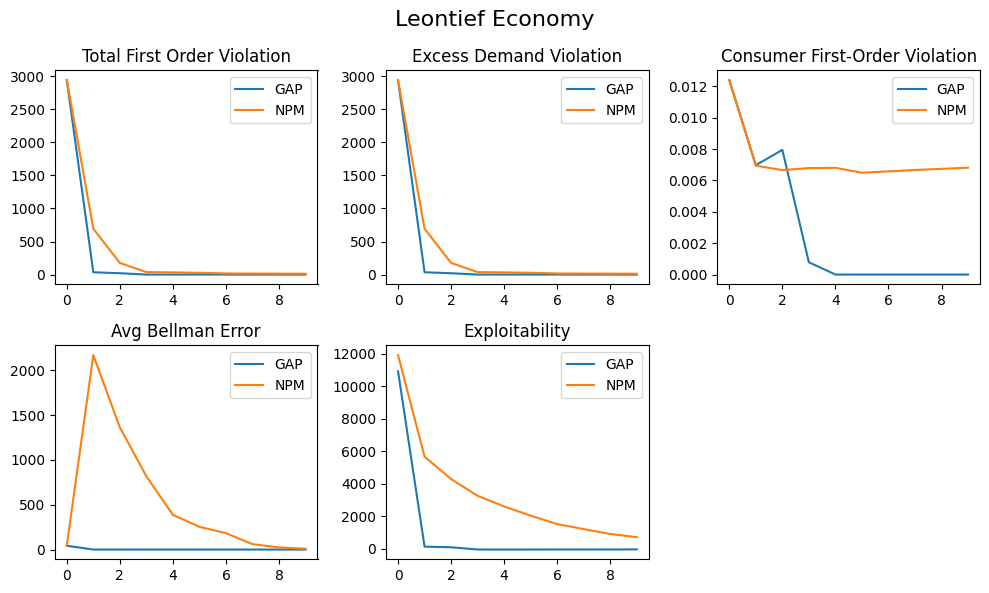

In [ ]:
plot_loss_overlay_dict(data_leontief, "Leontief Economy")

### Normalization

In [ ]:
num_samples_normal = 20
prng = hk.PRNGSequence(SEED)
num_samples = 10
num_epochs = 2000
num_epochs_exp = 1000
num_episodes = 30
gap_lr = 1e-5
br_lr = 1e-5
npm_lr = 1e-4
exp_lr = 1e-4
print_iter = 200

excess_demand_violations = []
consumer_first_order_violations = []
total_first_order_violations = []
avg_bellman_errors = []
exploitabilities = []
economy = economy_leontief

for i in range(num_samples_normal):
    print(f"----------------------------------------Sample {i}-----------------------------------------")
    eqm_network = hk.without_apply_rng(hk.transform(_eqm_network))
    eqm_params = eqm_network.init(next(prng), economy_leontief.get_initial_state(next(prng)), economy_leontief)
    eqm_generator = Policy(eqm_network, eqm_params)
    eqm_policy = lambda s: eqm_generator(s, economy)

    excess_demand_violation = EconomySimulator.estimate_first_order_seller_violation(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore
    consumer_first_order_violation = EconomySimulator.estimate_first_order_consumer_violation(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore
    total_first_order_loss = excess_demand_violation + consumer_first_order_violation #type: ignore
    avg_bellman_error = EconomySimulator.estimate_avg_bellman_error(economy, eqm_policy, num_samples, num_episodes, next(prng)) # type: ignore
    exploitability, br_policy = compute_exploitability(economy, eqm_params, exp_lr, num_epochs_exp, num_samples, num_episodes, print_iter=print_iter)
    if not (jnp.isnan(jnp.array(excess_demand_violation)) or jnp.isnan(jnp.array(consumer_first_order_violation)) or jnp.isnan(jnp.array(avg_bellman_error)) or jnp.isnan(jnp.array(exploitability[-1]))):
      print(excess_demand_violation)
      print(consumer_first_order_violation)
      print(avg_bellman_error)
      print("There is no nan! Store it.")
      excess_demand_violations.append(excess_demand_violation)
      consumer_first_order_violations.append(consumer_first_order_violation)
      total_first_order_violations.append(total_first_order_loss)
      avg_bellman_errors.append(avg_bellman_error)
      exploitabilities.append(exploitability[-1])



----------------------------------------Sample 0-----------------------------------------
==================== Epoch 0 ====================
Cumulative Regret: 11581.173828125
==================== Epoch 200 ====================
Cumulative Regret: 10067.83203125
==================== Epoch 400 ====================
Cumulative Regret: 11220.0595703125
==================== Epoch 600 ====================
Cumulative Regret: 10878.279296875
==================== Epoch 800 ====================
Cumulative Regret: 11928.458984375
2940.5154
0.012406023
293712.53
There is no nan! Store it.
----------------------------------------Sample 1-----------------------------------------
==================== Epoch 0 ====================
Cumulative Regret: 11346.3154296875
==================== Epoch 200 ====================
Cumulative Regret: 9950.4345703125
==================== Epoch 400 ====================
Cumulative Regret: 11174.9267578125
==================== Epoch 600 ====================
Cumulative Regr

In [ ]:
avg_excess_demand_violation = np.mean(excess_demand_violations)
avg_consumer_first_order_violation = np.mean(consumer_first_order_violations)
avg_total_first_order_loss = np.mean(total_first_order_loss)
avg_avg_bellman_error = np.mean(np.clip(avg_bellman_errors, a_min=1e-20, a_max=1e6))
avg_exploitability = np.mean(np.clip(exploitabilities, a_min=1e-20, a_max=1e6))

normal_data_leontief_stochastic = {"Total First Order Violation":      total_first_order_loss,
                   "Excess Demand Violation":          excess_demand_violations,
                   "Consumer First-Order Violation":   consumer_first_order_violations,
                   "Avg Bellman Error":                avg_bellman_errors,
                   "Exploitability":                   exploitabilities}

avg_data_leontief_stochastic = {"Total First Order Violation":      avg_total_first_order_loss,
                   "Excess Demand Violation":          avg_excess_demand_violation,
                   "Consumer First-Order Violation":   avg_consumer_first_order_violation,
                   "Avg Bellman Error":                avg_avg_bellman_error,
                   "Exploitability":                   avg_exploitability}

folder_name = "data"
os.makedirs(folder_name, exist_ok=True)

# Save the dictionaries as files inside the folder
avg_data_leontief_file = os.path.join(folder_name, "avg_data_leontief_stochastic.pkl")
normal_data_leontief_file = os.path.join(folder_name, "normal_data_leontief_stochastic.pkl")

# Save the dictionaries as files
with open(avg_data_leontief_file, "wb") as f:
    pickle.dump(avg_data_leontief_stochastic, f)
    pickle.dump(normal_data_leontief_stochastic, f)

# print(avg_data_leontief["Excess Demand Violation"])

NameError: name 'excess_demand_violations' is not defined

In [ ]:
# prompt: Normalize each data entry in data_leontief by the average value in avg_data_leontief

import pickle

# Load the data
with open("data/data_leontief_stochastic.pkl", "rb") as f:
    data_leontief = pickle.load(f)

# Load the average data
with open("data/avg_data_leontief_stochastic.pkl", "rb") as f:
    avg_data_leontief_stochastic = pickle.load(f)

# Normalize the data
normalized_data_leontief = {}
for key, value in data_leontief.items():
    normalized_data_leontief[key] = {}
    for subkey, subvalue in value.items():
        normalized_data_leontief[key][subkey] = np.array(subvalue) / avg_data_leontief_stochastic[key]



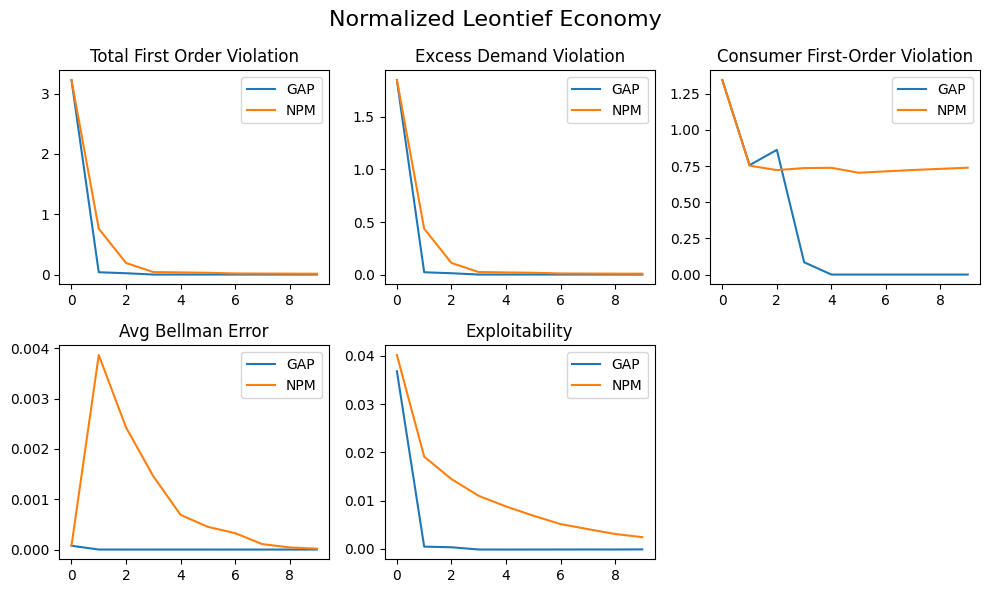

In [ ]:
plot_loss_overlay_dict(normalized_data_leontief, "Normalized Leontief Economy")

In [ ]:
three_normalized_data_leontief = {"Total First Order Violation":      normalized_data_leontief["Total First Order Violation"],
                   "Avg Bellman Error":                normalized_data_leontief["Avg Bellman Error"],
                   "Exploitability":                  normalized_data_leontief["Exploitability"]}

one_normalized_data_leontief = {"Exploitability":                  normalized_data_leontief["Exploitability"]}


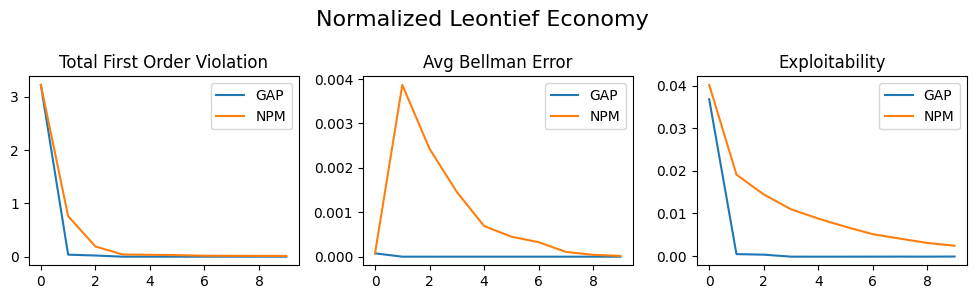

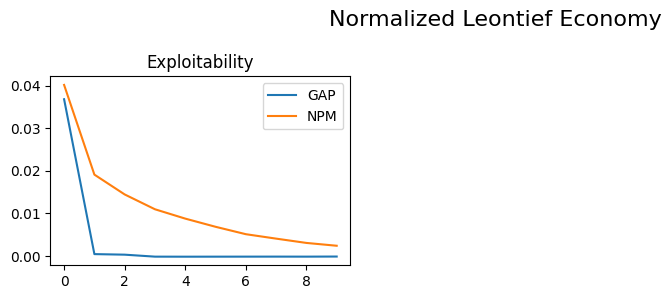

In [ ]:
plot_loss_overlay_dict(three_normalized_data_leontief, "Normalized Leontief Economy")
plot_loss_overlay_dict(one_normalized_data_leontief, "Normalized Leontief Economy")